#  0.0 Introdução 

## 0.1 Problema  de Negócio

Rossmann opera mais de 3.000 drogarias em 7 países europeus. Atualmente, os gerentes de loja da Rossmann têm a tarefa de prever suas vendas diárias com até seis semanas de antecedência. 

**Motivação:** A previsão de vendas foi requisitada pelo CFO em uma reunião mensal sobre os resultados das lojas. 

**Causa Raiz:** Necessidade de realizar reformas nas lojas, necessitando um aporte de dinheiro para concluir essas reformas. 

Assim, deve ser respondido as seguintes perguntas: 
- Qual sera o valor das vendas diarias para as lojas nas proximas 6 semanas? 

## 0.2 Planejamento da Entrega 

1. Resposta 
> previsão das vendas 

2. Formato de entrega
> Json com a previsão para cada loja 

3. Local de entrega 
> API 

## 0.3 Planejamento do Processo 

- Merger dados de treino e features de lojas pelo id da loja. 
- Tratamento de dados faltantes
- Mapa mental de Hipoteses. 
- Criação de novas Features e filtrar variaveis
- EDA
- Modelar dados(Normalização, rescaling, Encoding)
- Selecao de variaveis por importancia(Random Florest) 
- Modelar algoritmo e crosvalidation
- Fine tuning
- Avaliação do algoritmo e Performance de Negocio
- Criar Classe para preparar o dado e aplicar previsao
- Criar API Handler 
- Realizar Deploy

##  0.4 Planejamento de Entrega 

1. Fontes dos Dados
- **Kaggle** https://www.kaggle.com/c/rossmann-store-sales/data

2. Ferramentas 
- Python 3.8 
- jupyter Notebook 
- Pycharm
- sklearn
- coggle

# 1.0 Imports

In [1]:
# manipulacao de dados
import random
import numpy as np
import pandas as pd
from tabulate import tabulate
import pickle

#estatistica
import math
from scipy import stats
import scipy as misc


#graficos 
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image
from matplotlib.gridspec import GridSpec
from IPython.display       import Image
from IPython.core.display  import HTML

# manipulacoa de text 
import inflection

#time
import datetime

# ML
import xgboost as xgb
from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder

## 1.1 Funções de Ajuda

In [4]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
   
    
    sns.set()

def cramer_v(x , y):
    conf_matrix = pd.crosstab(x,y).values
    n = conf_matrix.sum()
    r, k = conf_matrix.shape
    
    chi2 = stats.chi2_contingency(conf_matrix)[0]
    
    chi2_corr = max(0, chi2 - (k-1) * (r-1)/(n-1))
    k_corr = k-(k-1)**2 / (n-1)
    r_corr = r - (r-1)**2 / (n-1)
    
    return np.sqrt((chi2_corr/n) / (min(k-1, r-1) ) )

def mean_percentage_error(y, yhat):
    return  np.mean((y-yhat)/y)
    
def mean_absolute_percentage_error(y, yhat):
    return  np.mean(np.abs((y-yhat)/y))

def ml_error(model_name, y, yhat):
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    
    return pd.DataFrame({'Nome modelo': model_name,
                        'MAE': mae,
                        'MAPE': mape,
                        'RMSE': rmse}, index=[0])

def cross_validation(x_training, kfold, model_name, model, verbose = False):
    l_mae = []
    l_mape = []
    l_rmse = []

    for k in reversed(range(1,kfold+1)):
        
        if verbose:
            print('\nKFold Numero: {}' .format(k))
        
        # comeco e fim da data para a validacao(cross-validation)
        validation_start_date = x_training['date'].max() - datetime.timedelta(days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta(days=(k-1)*6*7)

        #seperacao do dataset 
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        #treinamento e validacao dataset
        xtraining = training.drop(['date', 'sales'], axis =1)
        ytraining = training['sales']


        xvalidation = validation.drop(['date', 'sales'], axis =1)
        yvalidation = validation['sales']

        #modelo 
        ml = model.fit(xtraining, ytraining)

        #predicao 
        yhat= ml.predict(xvalidation)

        #performance 
        ml_result = ml_error('Regressao Linear', np.expm1(yvalidation), np.expm1(yhat))

        #armazena performance de cada iteracao do Kfold
        l_mae.append(ml_result['MAE'])
        l_mape.append(ml_result['MAPE'])
        l_rmse.append(ml_result['RMSE'])        

    return pd.DataFrame({'Modelo': model_name,
        'MAE CV': np.round(np.mean(l_mae), 2).astype(str) + ' +/- ' + np.round(np.std(l_mae), 2).astype(str),
        'MAPE CV': np.round(np.mean(l_mape), 2).astype(str) + ' +/- ' + np.round(np.std(l_mape), 2).astype(str),
        'RMSE CV': np.round(np.mean(l_rmse), 2).astype(str) + ' +/- ' + np.round(np.std(l_rmse), 2).astype(str)}, index = [0])

    

In [5]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 1.2 Carregando Dados

In [6]:
df_sales_raw = pd.read_csv('../data/raw/train.csv', low_memory=False)
df_store_raw = pd.read_csv('../data/raw/store.csv', low_memory=False)

In [7]:
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on = 'Store')

# 2.0 Analise Descritiva 

In [28]:
# check point 
df2 = df_raw.copy()

##  2.1 Renomear Colunas

In [29]:
cols_old = df2.columns
snake_case = lambda x : inflection.underscore(x)
cols_new = list(map(snake_case, cols_old))

# rename cols
df2.columns = cols_new

## 2.2 Dimensão dos Dados

O dataset possui 1017209 linhas e 18 colunas. 

In [30]:
df2.shape

(1017209, 18)

## 2.3 Tipo dos Atributos

In [31]:
# verificando o tipo dos atributos
df2.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [32]:
# Alterando o tipo da coluna 'date' de OBJECT para DATETIME
df2['date'] = pd.to_datetime(df2['date'], format='%Y-%m-%d')

## 2.4 Dados Faltantes(NA)

O dataset possui 6 colunas que contem linhas vazias. (podendo prejudicar a performance dos algoritmos)
- competition_distance
- competition_open_since_month
- competition_open_since_year
- promo2_since_week
- promo2_since_year
- promo_interval

**Por que estao NA? Regra de negocio?**

In [33]:
df2.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 2.5 Preenchendo NA 

In [34]:
df2['competition_distance'].max()

75860.0

In [35]:
# competition_distance
df2['competition_distance'] = df2['competition_distance'].apply(lambda x : 200000.0 if math.isnan(x) 
                                                                else x )

# competition_open_since_month
df2['competition_open_since_month'] = df2.apply(lambda x : x['date'].month 
                                                if math.isnan(x['competition_open_since_month']) 
                                                                else x['competition_open_since_month'], axis=1 )

# competition_open_since_year
df2['competition_open_since_year'] = df2.apply(lambda x : x['date'].year 
                                                if math.isnan(x['competition_open_since_year']) 
                                                                else x['competition_open_since_year'], axis=1 )
# promo2_since_week
df2['promo2_since_week'].fillna(0, inplace=True)

# promo2_since_year
df2['promo2_since_year'].fillna(0, inplace=True)

# promo_interval
month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct'
             , 11: 'Nov', 12: 'Dec'}

df2['promo_interval'].fillna(0, inplace=True)
df2['month_map'] = df2['date'].dt.month.map(month_map)

df2['is_promo2'] = df2[['promo_interval', 'month_map']].apply(lambda x : 0 if x['promo_interval'] == 0 else
                                                              1 if x['month_map'] in x['promo_interval'].split(',')
                                                              else 0, axis=1)


In [36]:
df2.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo2                                int64
dtype: object

## 2.6 Alterando Data Type 

In [37]:
# alterando o tipo dos catributos 'promo2_since_week', 'promo2_since_year' para int 
df2['promo2_since_week'] = df2['promo2_since_week'].astype(int)
df2['promo2_since_year'] = df2['promo2_since_year'].astype(int)

# alterando o tipo dos catributos 'competition_open_since_month', 'competition_open_since_year' para int 
df2['competition_open_since_month'] = df2['competition_open_since_month'].astype(int)
df2['competition_open_since_year'] = df2['competition_open_since_year'].astype(int)

## 2.7 Estatística Descritiva  

In [38]:
num_attributes = ['customers','store' ,'day_of_week', 'sales', 'competition_distance', 
                  'competition_open_since_month', 'competition_open_since_year', 'promo2_since_week',
                 'promo2_since_year']
cat_attributes = ['open','promo', 'state_holiday', 'school_holiday', 'store_type', 'assortment', 'promo2',
                 'promo_interval', 'month_map', 'is_promo2']

### 2.6.1 Atributos Numericos 

In [17]:
# calculando a Kurtosis e skew dos atributos numericos 
num_kurtosis = df2[num_attributes].apply(lambda x : x.kurtosis())
num_skew = df2[num_attributes].apply(lambda x : x.skew())
df_kurt_skew = pd.DataFrame([num_kurtosis, num_skew]).T
df_kurt_skew.columns = ['kurtosis', 'skew']

In [18]:
df_describe = df2[num_attributes].describe().T

In [19]:
pd.concat([df_describe, df_kurt_skew], axis = 1)

,count,mean,std,min,25%,50%,75%,max,kurtosis,skew
customers,1017209.0,633.145946,464.411734,0.0,405.0,609.0,837.0,7388.0,7.091773,1.598650
store,1017209.0,558.429727,321.908651,1.0,280.0,558.0,838.0,1115.0,-1.200524,-0.000955
day_of_week,1017209.0,3.998341,1.997391,1.0,2.0,4.0,6.0,7.0,-1.246873,0.001593
sales,1017209.0,5773.818972,3849.926175,0.0,3727.0,5744.0,7856.0,41551.0,1.778375,0.641460
competition_distance,1017209.0,5935.442677,12547.652996,20.0,710.0,2330.0,6910.0,200000.0,147.789712,10.242344
competition_open_since_month,1017209.0,6.786849,3.311087,1.0,4.0,7.0,10.0,12.0,-1.232607,-0.042076
competition_open_since_year,1017209.0,2010.324840,5.515593,1900.0,2008.0,2012.0,2014.0,2015.0,124.071304,-7.235657
promo2_since_week,1017209.0,11.647665,15.323928,0.0,0.0,1.0,22.0,50.0,-0.498322,1.003390
promo2_since_year,1017209.0,1007.010608,1005.876930,0.0,0.0,2009.0,2012.0,2015.0,-1.999993,-0.002251


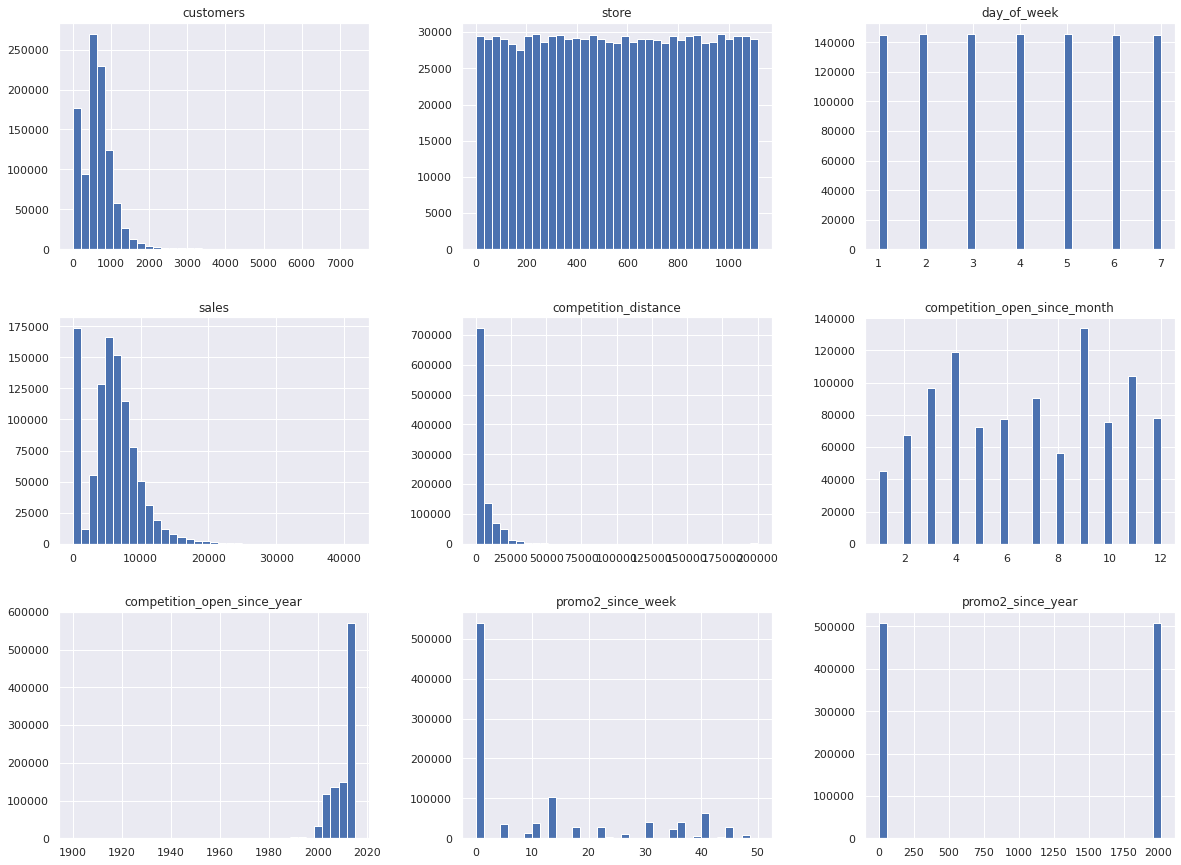

In [20]:
df2[num_attributes].hist(bins = 35, figsize = (20,15));

### 2.6.2 Atributos Categoricos

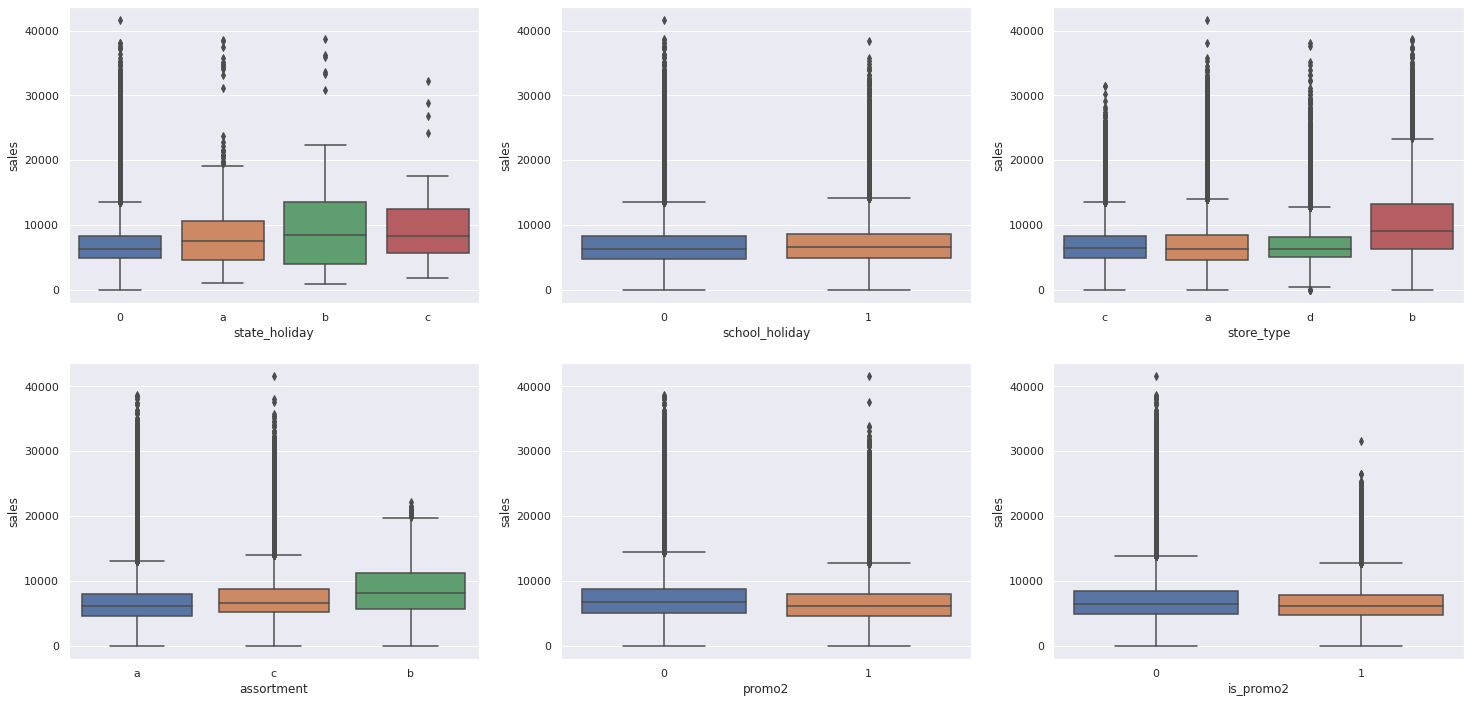

In [21]:
# state_holiday
aux = df2[df2['open']==1]
plt.subplot(2,3,1)
sns.boxplot(x = 'state_holiday', y ='sales', data=aux);

#school_holiday
plt.subplot(2,3,2)
sns.boxplot(x = 'school_holiday', y ='sales', data=aux);

#store_type
plt.subplot(2,3,3)
sns.boxplot(x = 'store_type', y ='sales', data=aux);


#assortment
plt.subplot(2,3,4)
sns.boxplot(x = 'assortment', y ='sales', data=aux);

#assortment
plt.subplot(2,3,5)
sns.boxplot(x = 'promo2', y ='sales', data=aux);


#assortment
plt.subplot(2,3,6)
sns.boxplot(x = 'is_promo2', y ='sales', data=aux);



# 3.0 Feature Engineering  

In [40]:
df3 = df2.copy()

## 3.1 Mapa Mental de Hipoteses 

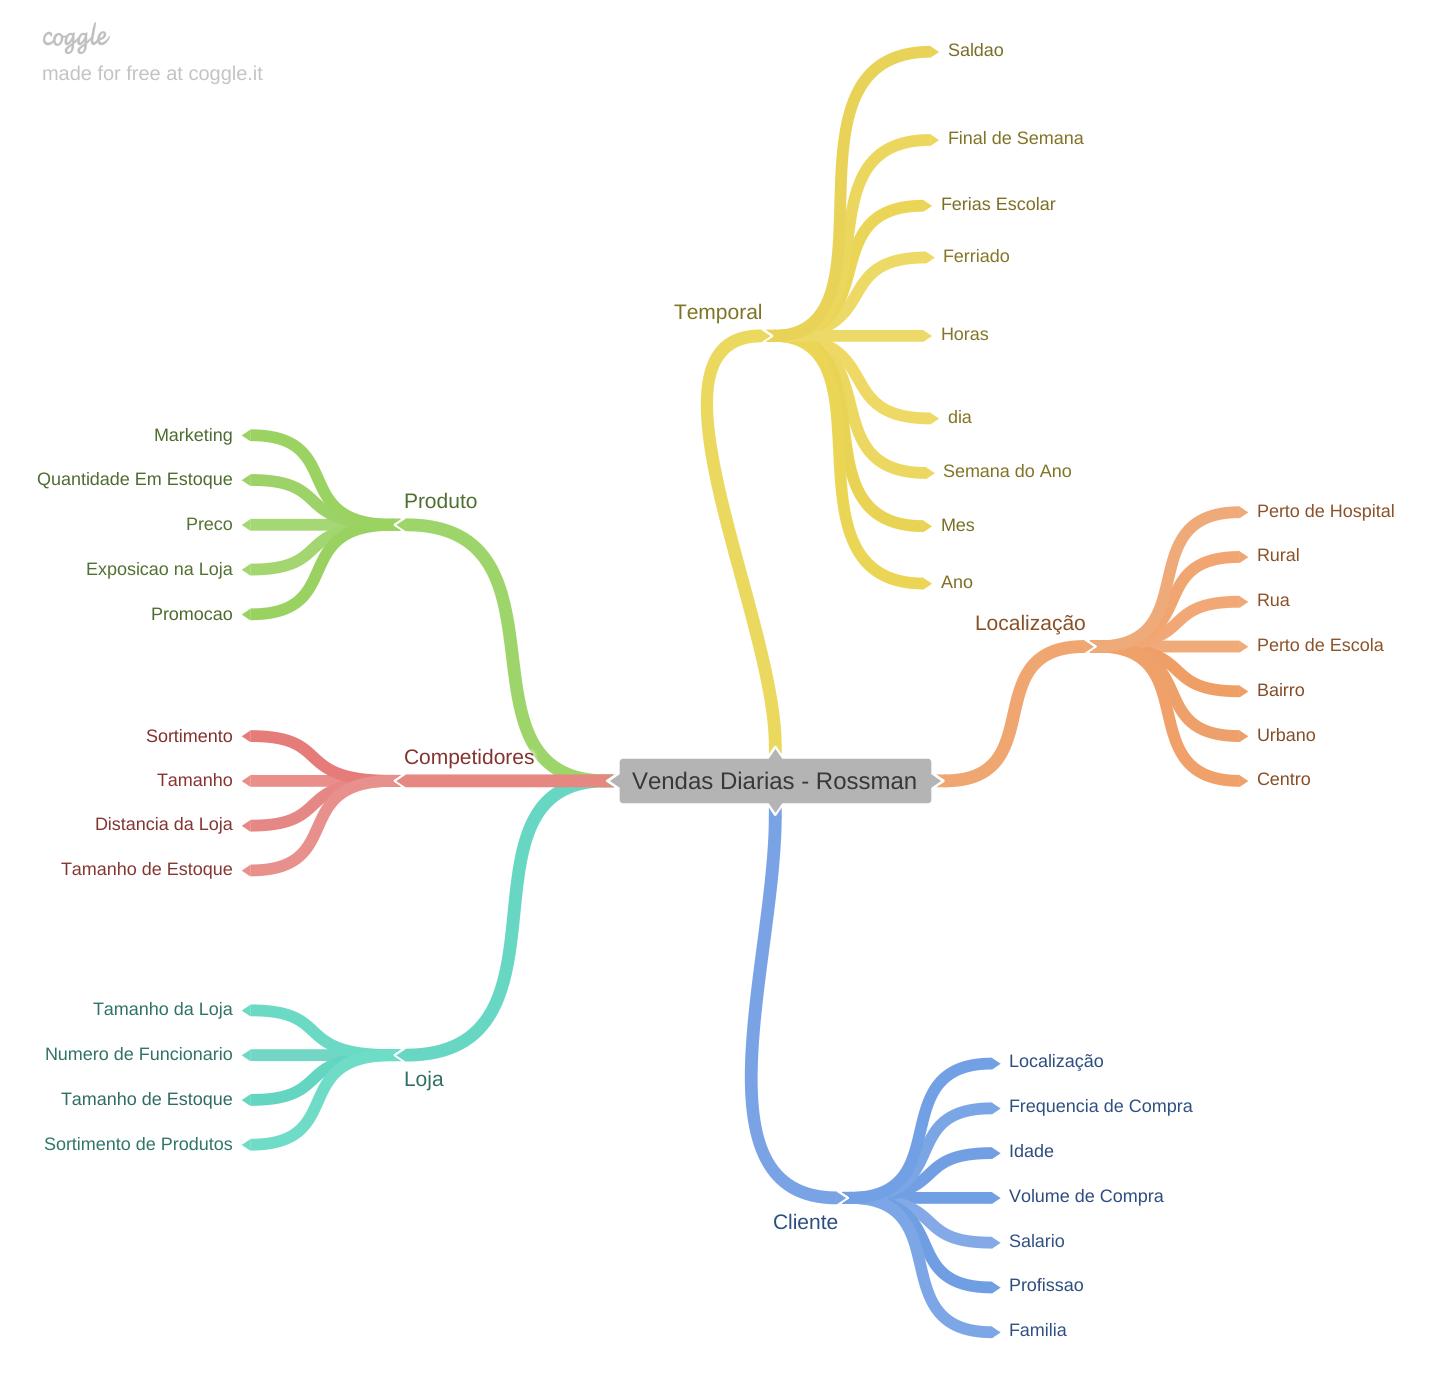

In [23]:
Image('../img/Vendas_Diarias_-_Rossman.png')

##  3.2 Hipoteses

### 3.2.1 Hipoteses Loja

**1.** Lojas do tipo **D** vendem 20% a mais que os demais tipos.

**2.** Lojas com o sortimento de produtos do tipo **c**(extendido) devem vender 10% a mais que os demais tipos.  

**3.** Lojas com numero de funcionarios superior a 20 vendem 5% a mais que outras lojas. 

**4.** Lojas com maior estoque devem vender 10% a mais. 

### 3.2.2 Hipoteses Produto

**1.** Lojas que investem 5% a mais em marketing vendem 10% a mais.

**2.** Lojas com produto exposto na vitrine deveriam vender mais.

**3.** Lojas com produtos com preco 5% menor deveriam vender 10% mais. 

**4.** Lojas com 10% de desconto deveriam vender 15% mais. 

**5.** Lojas com grande quantidade do produtos em estoque deveriam vender 10% mais.

### 3.2.3 Hipoteses Tempo

**1.** Lojas vendem 15% mais no natal do que em outros feriados.

**2.** Lojas deveriam vender 5% a mais ao longo dos anos. 

**3.** Lojas abertas no feriados vendem 20% menos. 

**4.** Lojas vendem 10% a mais no final de semana. 

**5.** Lojas vendem 20% mais no segundo semestre do ano.

**6.** Lojas vendem 15% menos durante ferias escolares.

**7.** Lojas que entram em promocao consecutivas vendem 20% mais. 

**8.** Lojas que ficam mais de 2 meses em promocao vendem 10% menos. 

### 3.2.4 Hipoteses Competidores

**1.** Lojas com competidores a menos de 1000m de distancia vendem 10% 

## 3.3 Lista Final de Hipoteses 

**1.** Lojas do tipo **D** vendem 20% a mais que os demais tipos.

**2.** Lojas com o sortimento de produtos do tipo **c**(extendido) devem vender 10% a mais que os demais tipos.  

**3.** Lojas com competidores a menos de 1000m de distancia vendem 10% 

**6.** Lojas que entram em promocao consecutivas vendem 20% mais. 

**7.** Lojas que ficam mais de 2 meses em promocao vendem 10% menos. 

**4.** Lojas vendem 15% mais no natal do que em outros feriados.

**8.** Lojas deveriam vender 5% a mais ao longo dos anos. 

**10.** Lojas vendem 10% a mais no final de semana. 

**11.** Lojas vendem 20% mais no segundo semestre do ano.

**12.** Lojas vendem 15% menos durante ferias escolares.

## 3.4 Feature Engineering  

In [41]:
#year
df3['year'] = df3['date'].dt.year

#month
df3['month'] = df3['date'].dt.month

#day
df3['day'] = df3['date'].dt.day

#week of year
df3['week_of_year'] = df3['date'].dt.weekofyear
                
#year week
df3['year_week'] = df3['date'].dt.strftime('%Y-%W')


#promo Since
df3['promo2_since'] = df3['promo2_since_year'].astype(str) + '-' + df3['promo2_since_week'].astype(str)
df3['promo2_since'] = df3['promo2_since'].apply(lambda x : 0 if x == '0-0' else datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
df3['promo2_time_week'] = df3.apply(lambda x: 0 if x['promo2_since'] == 0 else ((x['date']-x['promo2_since'])/7).days, axis=1).astype(int)

#assortiment
df3['assortment'] = df3['assortment'].apply(lambda x : 'basic' if  x=='a'  else 'extra' if x=='b' else 'extended')

#state holiday
df3['state_holiday'] = df3['state_holiday'].apply(lambda x : 'public holiday' if  x=='a' else 'easter holiday' if x=='b' 
                                                  else 'christmas' if x=='c' else 'regular day')

/tmp/ipykernel_3460/3175737312.py:11: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df3['week_of_year'] = df3['date'].dt.weekofyear


# 4.0 Filtragem de Atributos  

In [43]:
df4 = df3.copy()

## 4.1 Filtragem das Linhas 

In [44]:
df4 = df4[(df4['open']!=0) & (df4['sales']> 0) ] 

## 4.2  Filtragem das Colunas 

In [45]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df4 = df4.drop(cols_drop, axis=1)

# 5.0 Analise Exploratoria de Dados - EDA 

In [47]:
df5 = df4.copy()

In [29]:
num_attributes = ['store' ,'day_of_week', 'sales', 'competition_distance', 'competition_open_since_month', 
                  'competition_open_since_year', 'promo2_since_week', 'promo2_since_year', 
                  'promo2_time_week', 'week_of_year', 'year', 'month', 'day' ,'promo2_since', 'year_week']

cat_attributes = ['promo', 'state_holiday', 'school_holiday', 'store_type', 'assortment', 'promo2', 'is_promo2']

## 5.1 Univariada

### 5.1.1 Variavel Resposta 

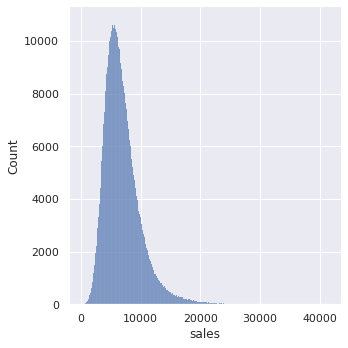

In [30]:
sns.displot(data = df5, x='sales');

### 5.1.2 Variaveis Numericas

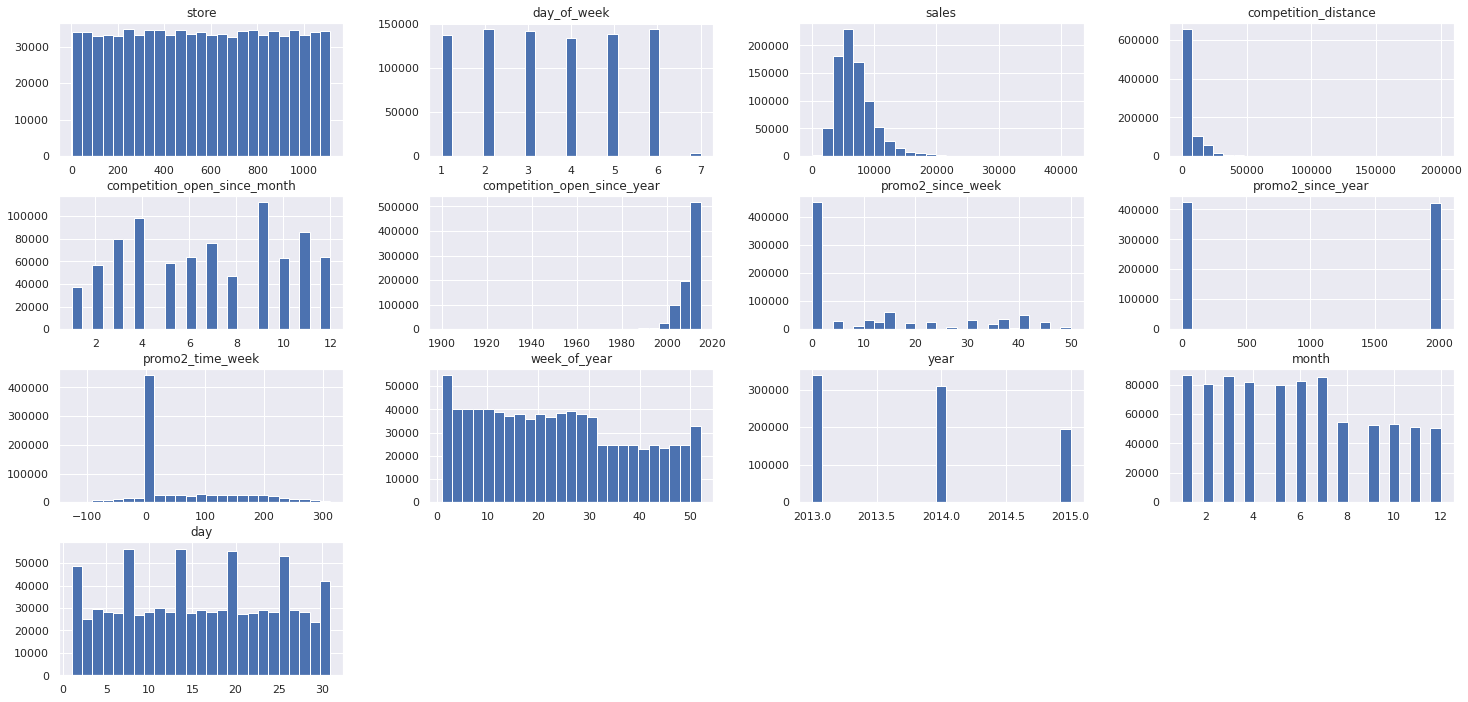

In [31]:
df5[num_attributes].hist(bins = 25);

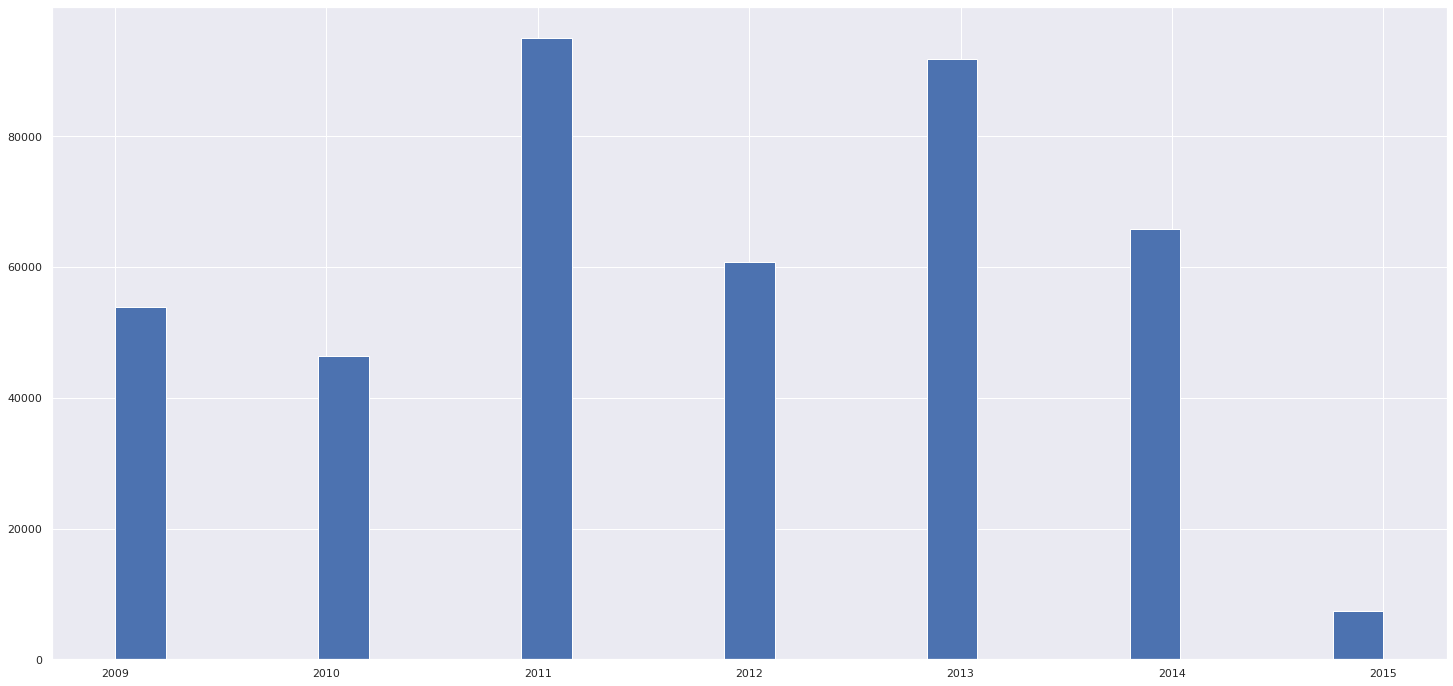

In [32]:
df5[df5['promo2_since_year']!=0]['promo2_since_year'].hist(bins=25);

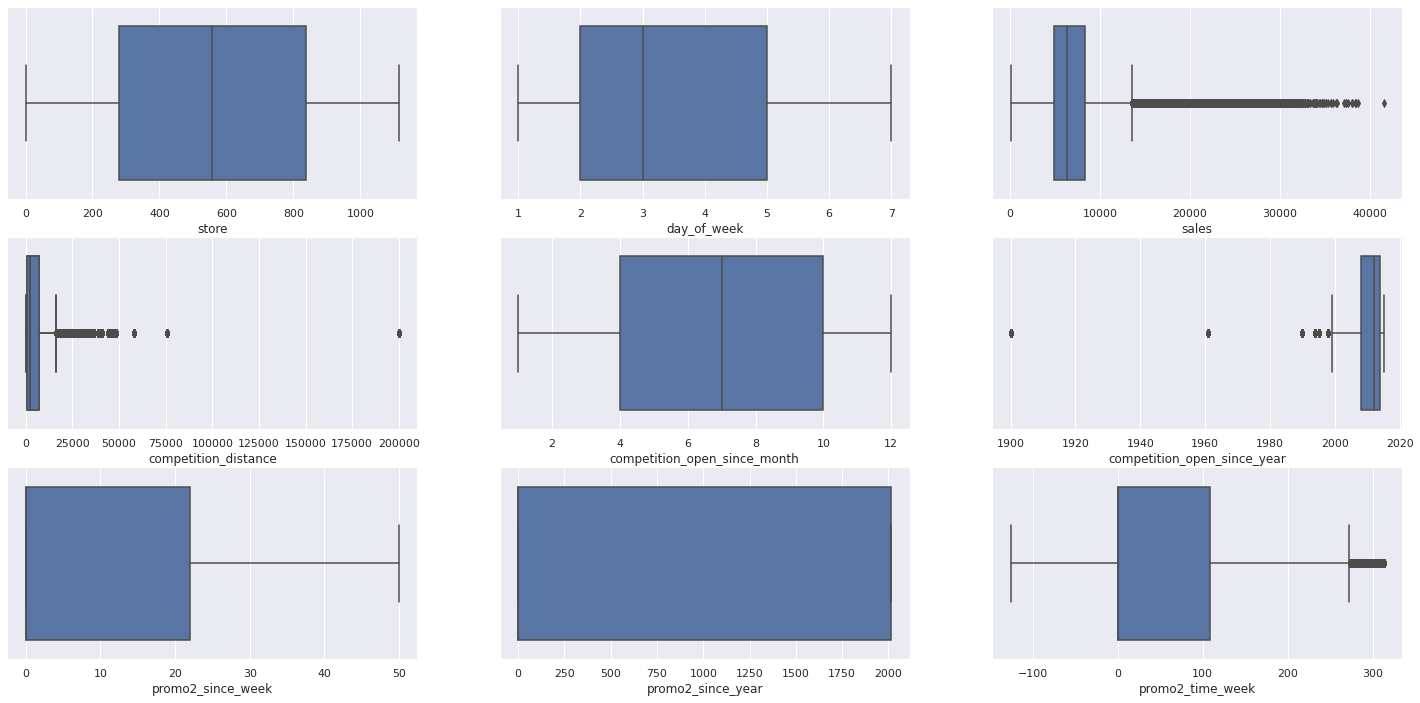

In [33]:
plt.subplot(3,3,1)
sns.boxplot(x = df5['store']);

plt.subplot(3,3,2)
sns.boxplot(x = df5['day_of_week']);

plt.subplot(3,3,3)
sns.boxplot(x = df5['sales']);

plt.subplot(3,3,4)
sns.boxplot(x = df5['competition_distance']);

plt.subplot(3,3,4)
sns.boxplot(x = df5['competition_distance']);

plt.subplot(3,3,5)
sns.boxplot(x = df5['competition_open_since_month']);

plt.subplot(3,3,6)
sns.boxplot(x = df5['competition_open_since_year']);

plt.subplot(3,3,7)
sns.boxplot(x = df5['promo2_since_week']);

plt.subplot(3,3,8)
sns.boxplot(x = df5['promo2_since_year']);

plt.subplot(3,3,9)
sns.boxplot(x = df5['promo2_time_week']);

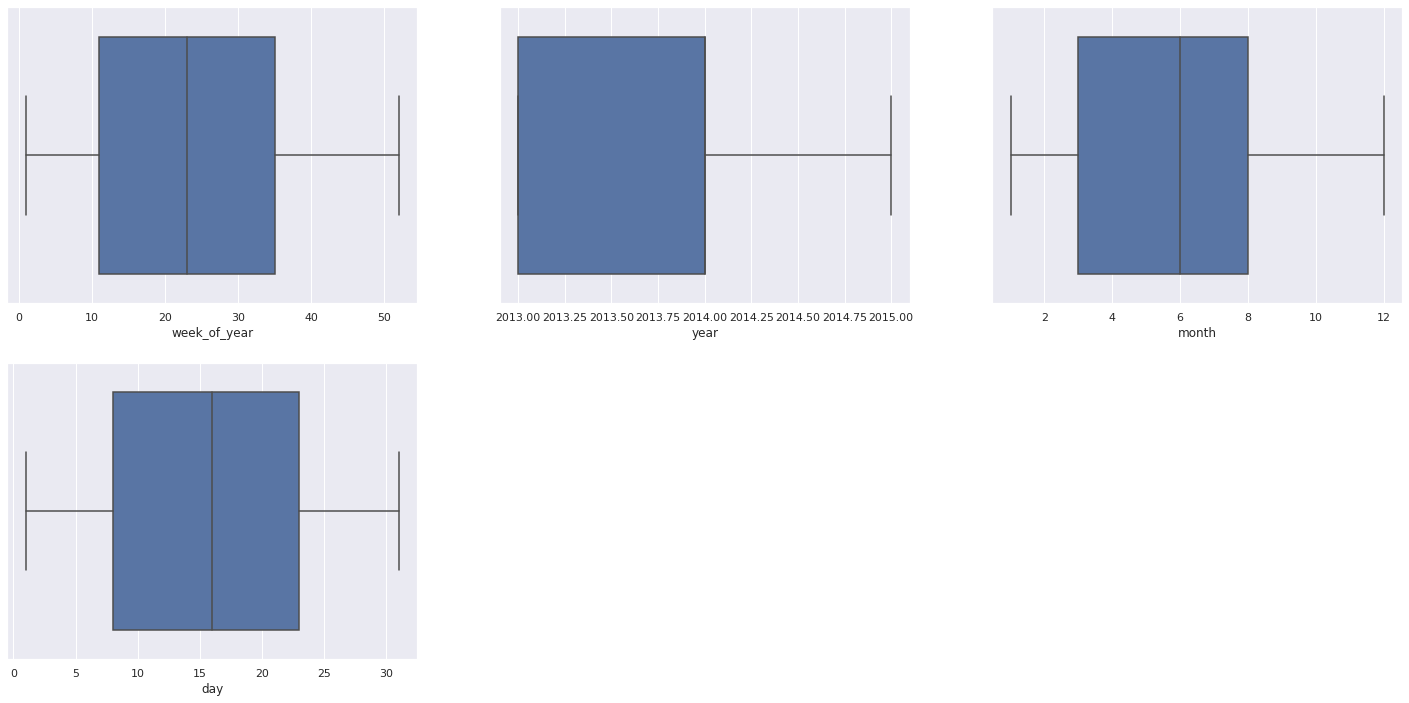

In [34]:
plt.subplot(2,3,1)
sns.boxplot(x = df5['week_of_year']);

plt.subplot(2,3,2)
sns.boxplot(x = df5['year']);

plt.subplot(2,3,3)
sns.boxplot(x = df5['month']);

plt.subplot(2,3,4)
sns.boxplot(x = df5['day']);


### 5.1.3 Variaveis Categoricas 

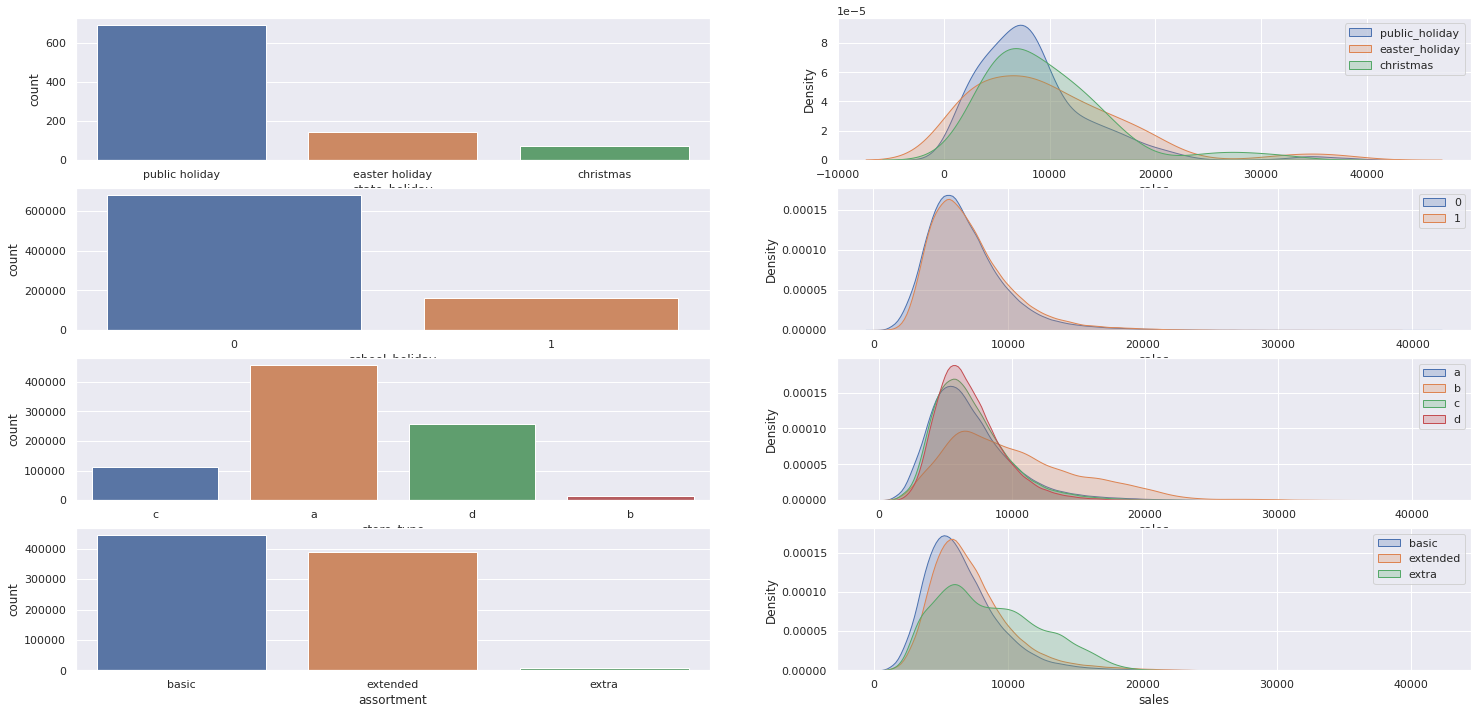

In [35]:
# state_holiday
plt.subplot(4,2,1)
sns.countplot( x ='state_holiday', data=df5[df5['state_holiday']!='regular day']);

plt.subplot(4,2,2)
sns.kdeplot(df5[df5['state_holiday']=='public holiday']['sales'],label = 'public_holiday' ,shade=True );
sns.kdeplot(df5[df5['state_holiday']=='easter holiday']['sales'],label = 'easter_holiday', shade=True);
sns.kdeplot(df5[df5['state_holiday']=='christmas']['sales'],label = 'christmas', shade=True);
plt.legend();

# school_holiday
plt.subplot(4,2,3)
sns.countplot( x ='school_holiday', data=df5);

plt.subplot(4,2,4)
sns.kdeplot(df5[df5['school_holiday']==0]['sales'],label = '0', shade=True );
sns.kdeplot(df5[df5['school_holiday']==1]['sales'],label = '1', shade=True);
plt.legend();

# store_type
plt.subplot(4,2,5)
sns.countplot( x ='store_type', data=df5);

plt.subplot(4,2,6)
sns.kdeplot(df5[df5['store_type']=='a']['sales'],label = 'a', shade=True );
sns.kdeplot(df5[df5['store_type']=='b']['sales'],label = 'b', shade=True);
sns.kdeplot(df5[df5['store_type']=='c']['sales'],label = 'c', shade=True);
sns.kdeplot(df5[df5['store_type']=='d']['sales'],label = 'd', shade=True);
plt.legend();

# assortment
plt.subplot(4,2,7)
sns.countplot( x ='assortment', data=df5);

plt.subplot(4,2,8)
sns.kdeplot(df5[df5['assortment']=='basic']['sales'],label = 'basic', shade=True );
sns.kdeplot(df5[df5['assortment']=='extended']['sales'],label = 'extended', shade=True);
sns.kdeplot(df5[df5['assortment']=='extra']['sales'],label = 'extra', shade=True);
plt.legend();

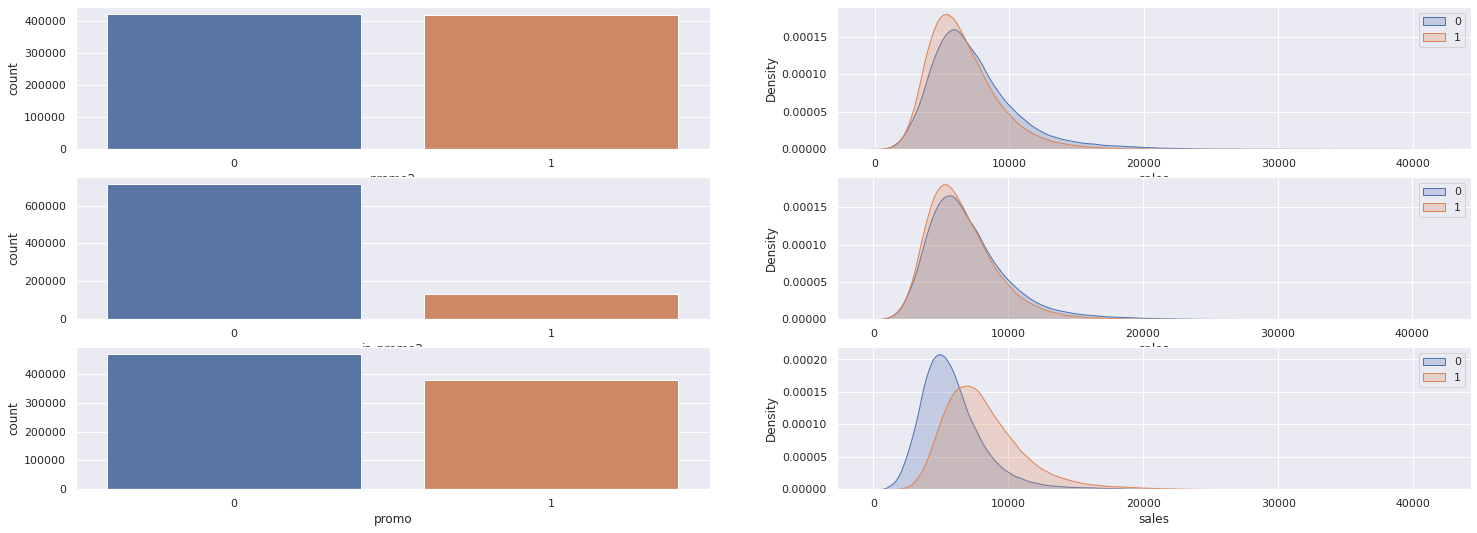

In [36]:
# promo2
plt.subplot(4,2,1)
sns.countplot( x ='promo2', data=df5);

plt.subplot(4,2,2)
sns.kdeplot(df5[df5['promo2']==0]['sales'],label = '0' ,shade=True );
sns.kdeplot(df5[df5['promo2']==1]['sales'],label = '1', shade=True);
plt.legend();

# is_promo2
plt.subplot(4,2,3)
sns.countplot( x ='is_promo2', data=df5);

plt.subplot(4,2,4)
sns.kdeplot(df5[df5['is_promo2']==0]['sales'],label = '0' ,shade=True );
sns.kdeplot(df5[df5['is_promo2']==1]['sales'],label = '1', shade=True);
plt.legend();

# promo
plt.subplot(4,2,5)
sns.countplot( x ='promo', data=df5);

plt.subplot(4,2,6)
sns.kdeplot(df5[df5['promo']==0]['sales'],label = '0' ,shade=True );
sns.kdeplot(df5[df5['promo']==1]['sales'],label = '1', shade=True);
plt.legend();

## 5.2 Bivariada

### **H1.** Lojas do tipo **D** vendem 20% a mais que os demais tipos.
**Falso** Lojas do tipo D vendem 45% menos que do tipo A

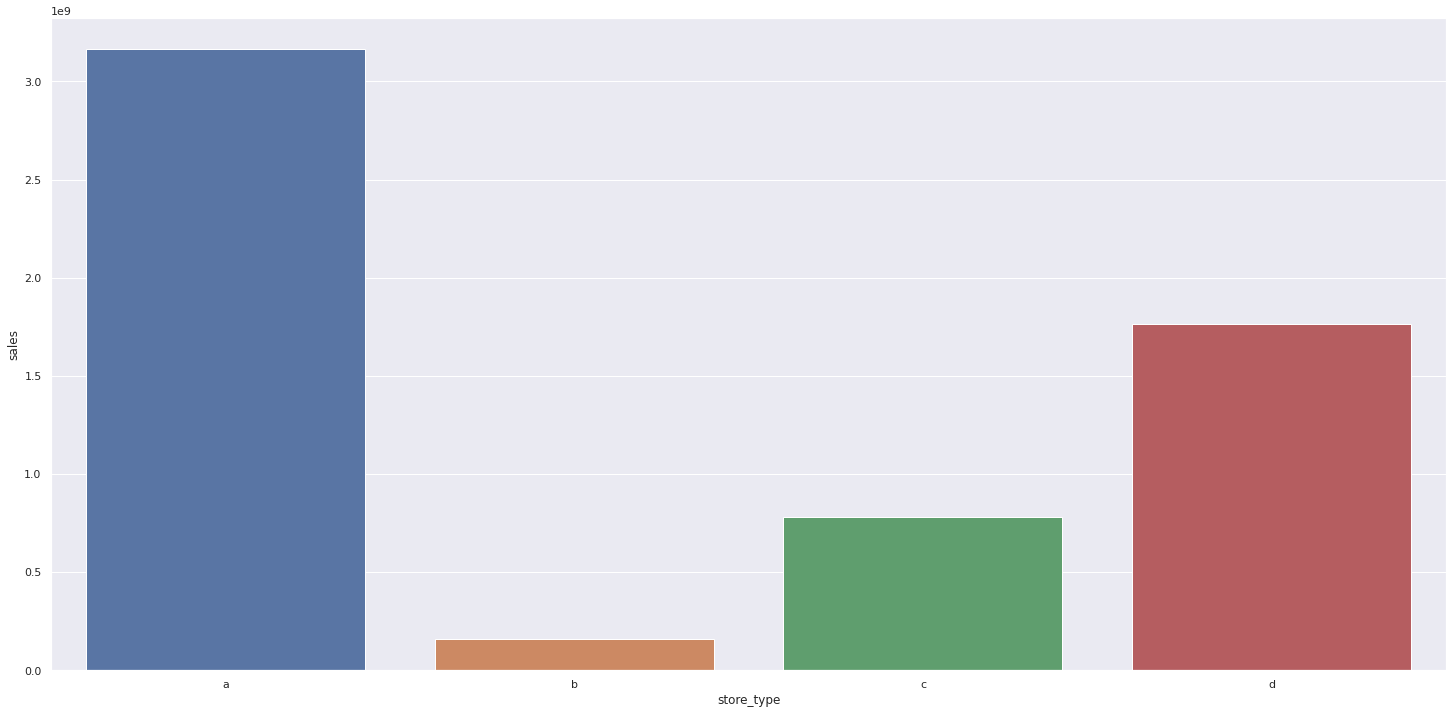

In [37]:
sum_sales_type = df5[['store_type', 'sales']].groupby('store_type').sum().reset_index()
sns.barplot(x = 'store_type', y = 'sales', data = sum_sales_type);

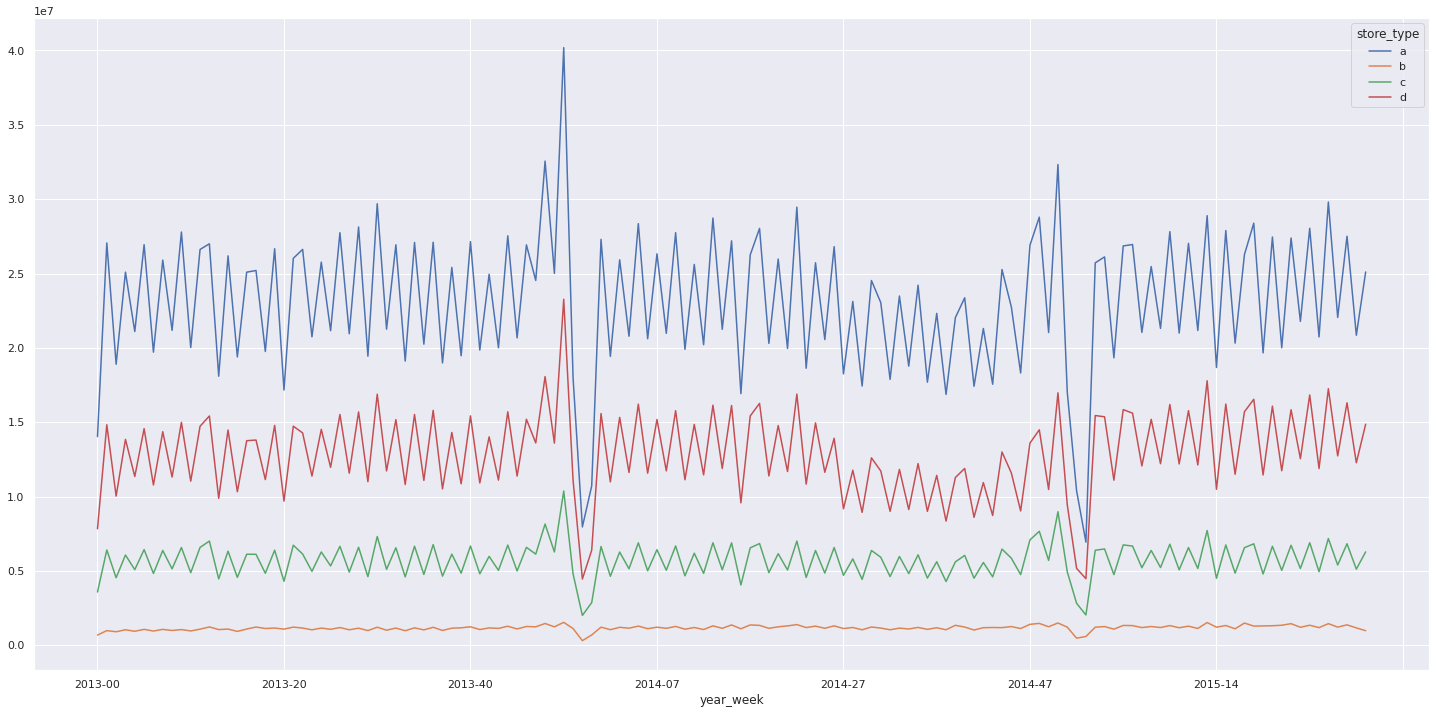

In [38]:
sales_type_week = df5[['store_type', 'sales', 'year_week']].groupby(['store_type', 'year_week']).sum().reset_index()
sales_type_week.pivot(index='year_week', columns= 'store_type', values='sales').plot();

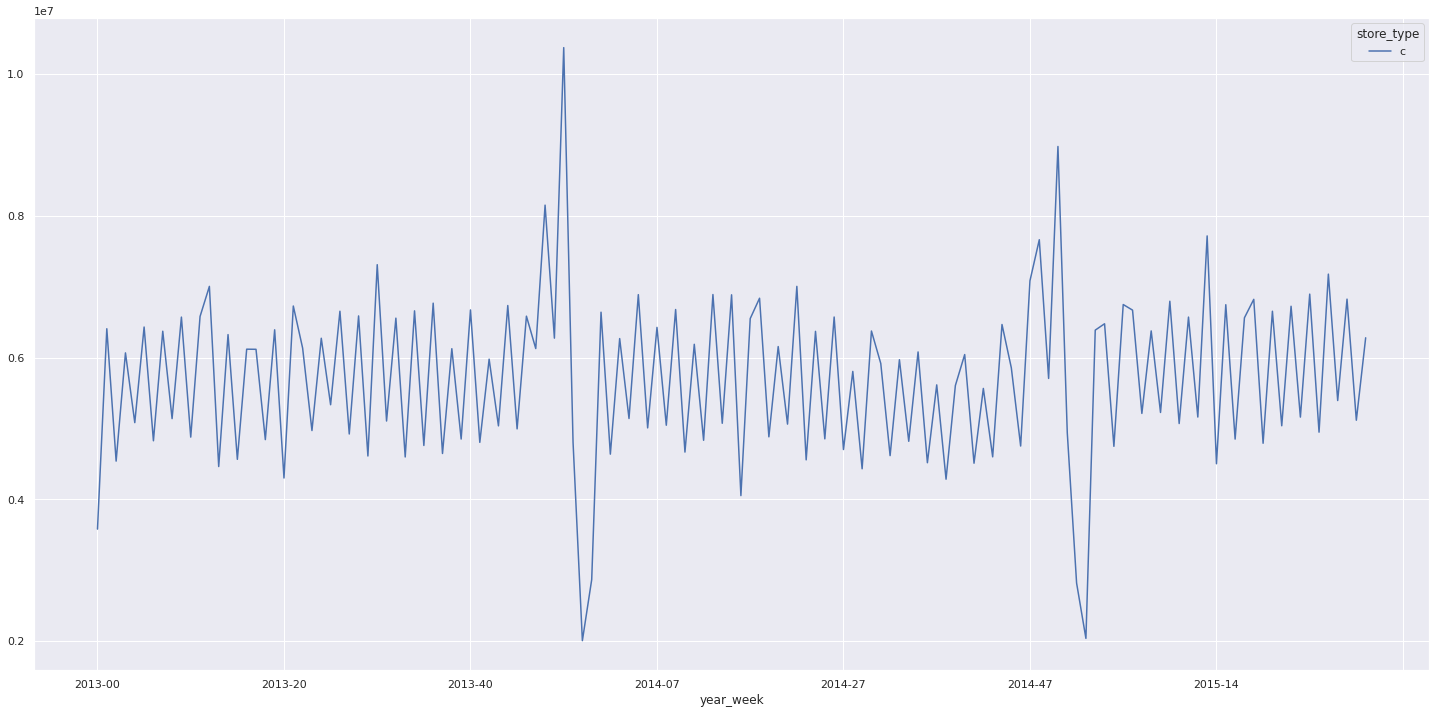

In [39]:
aux = sales_type_week[sales_type_week['store_type']=='c']
aux.pivot(index='year_week', columns= 'store_type', values='sales').plot();

In [40]:
type_a = sum_sales_type[sum_sales_type['store_type']=='a']['sales'].values
type_d = sum_sales_type[sum_sales_type['store_type']=='d']['sales'].values

((type_a-type_d)*100)/type_a

array([44.22729279])

- como visto lojas do tipo D vendem 44% a menos do que o tipo A
- Lojas do tipo D sao as segundas em maiores vendas. 
- Mesmo tendo um volume de vendas diferentes as lojas possuem um comportamento similar durante o tempo

### **H2.** Lojas com o sortimento de produtos do tipo **c**(extendido) devem vender 10% a mais que os demais tipos.  
**Falso** Lojas com o sortimento extendindo vendem 3% a menos que o Basico

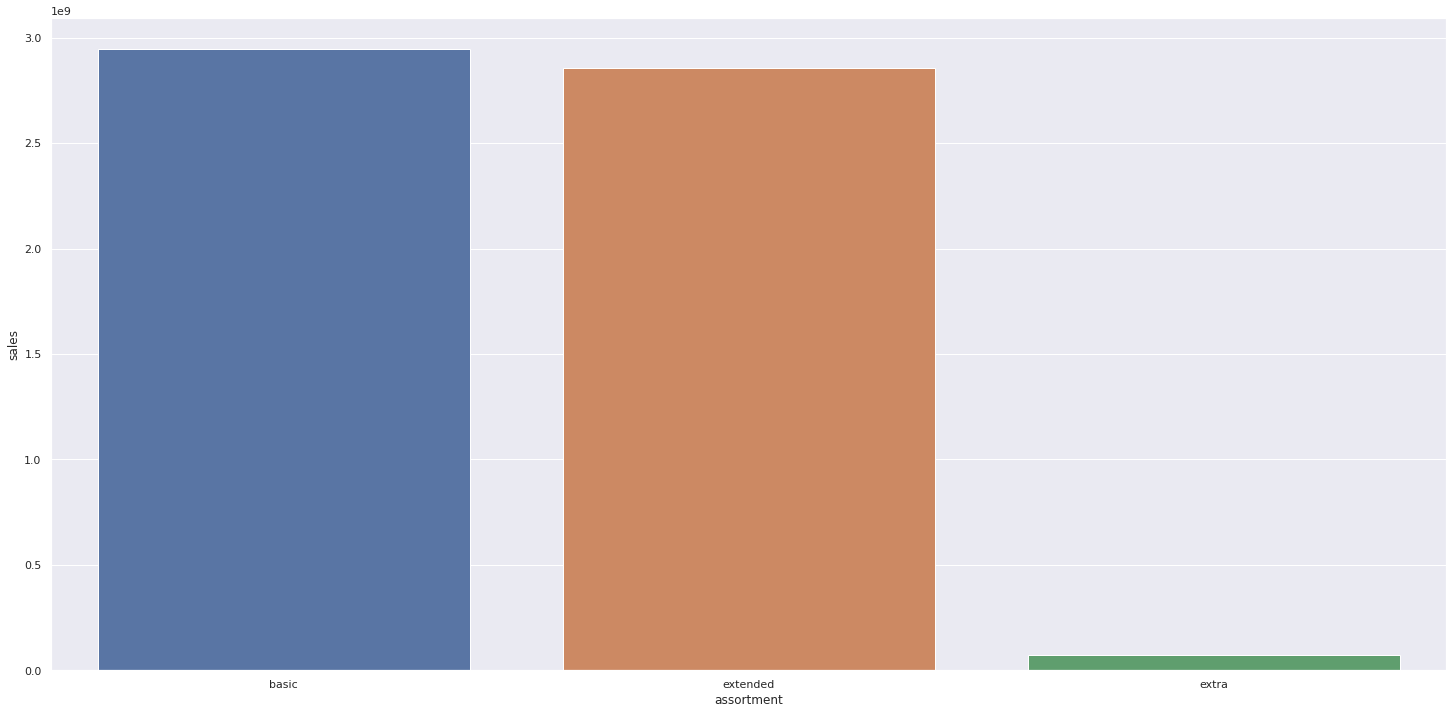

In [41]:
sum_sales_assortment = df5[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x = 'assortment', y = 'sales', data = sum_sales_assortment);

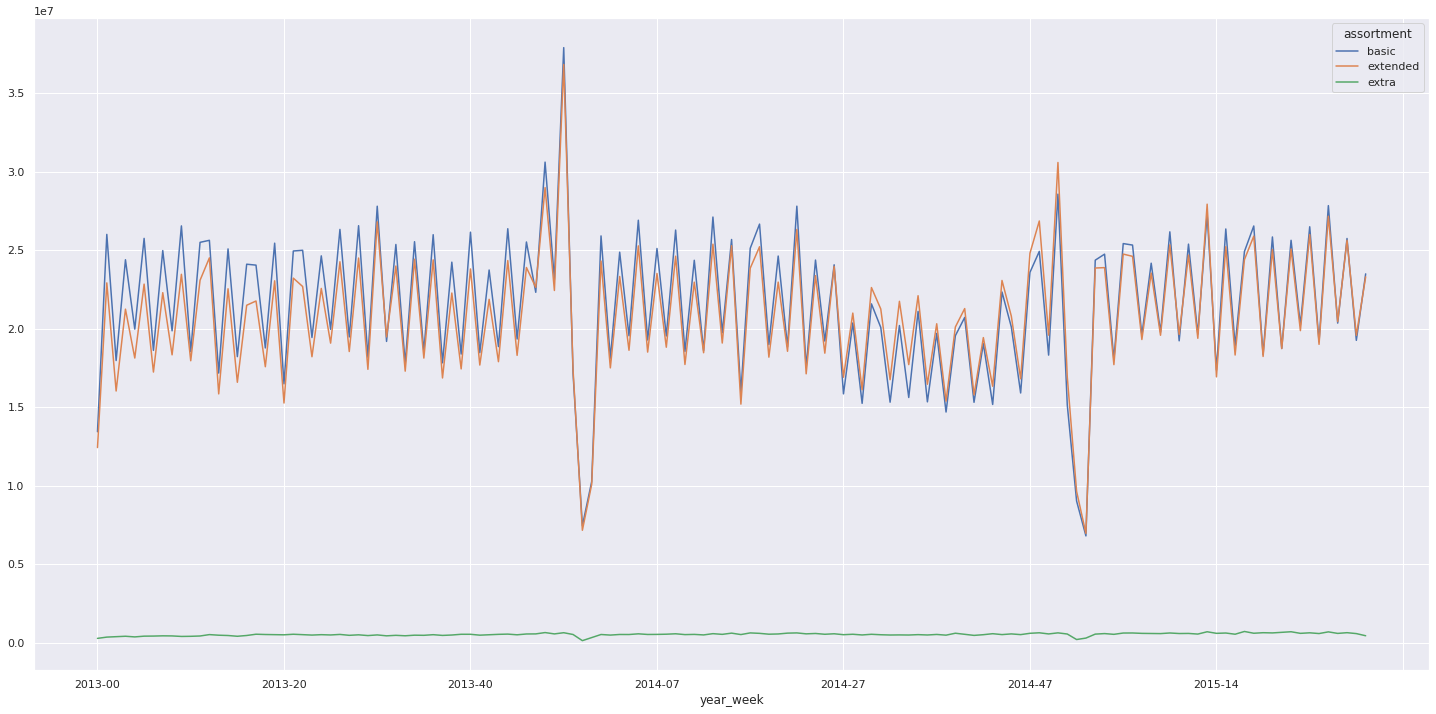

In [42]:
sales_assortment_week = df5[['assortment', 'sales', 'year_week']].groupby(['assortment', 'year_week']).sum().reset_index()
sales_assortment_week.pivot(index='year_week', columns= 'assortment', values='sales').plot();

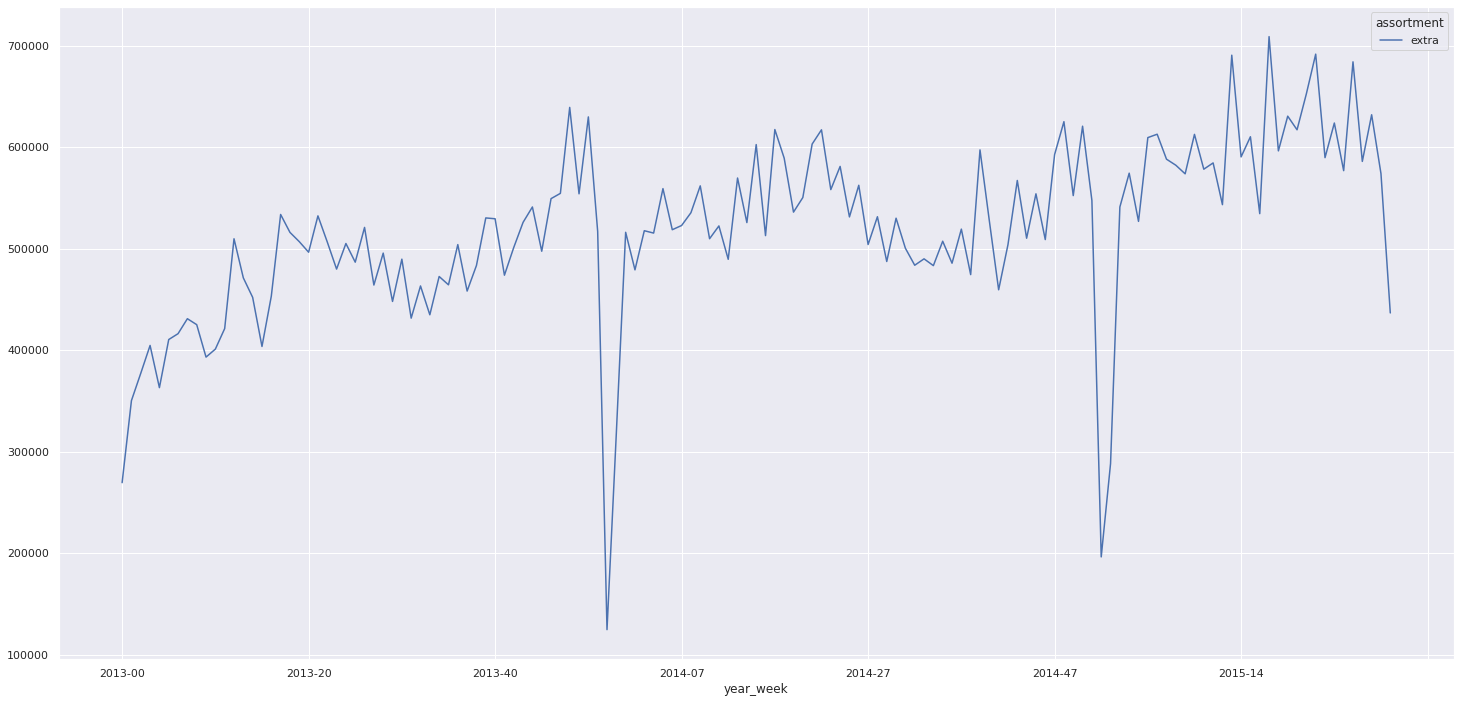

In [43]:
aux = sales_assortment_week[sales_assortment_week['assortment']=='extra']
aux.pivot(index='year_week', columns= 'assortment', values='sales').plot();

In [44]:
sales_assortment_week[sales_assortment_week['assortment']!='extra'].sort_values('sales')

,assortment,year_week,sales
106,basic,2015-00,6797390
243,extended,2015-00,6953578
189,extended,2013-52,7156783
52,basic,2013-52,7445664
105,basic,2014-52,9020372
...,...,...,...
185,extended,2013-48,28990279
240,extended,2014-50,30587863
48,basic,2013-48,30611693
187,extended,2013-50,36835578


- Lojas com sortimento Extendido vendem 3% a menos se comparado com as lojas de sortimento basico. 
- Lojas com sortimento Extendido vendem 97% a mais que lojas com sortimento Extra
- Lojas com sortimento Basico e Extendido possuem um comportamento similar atraves das semanas. 
- Durante as semans 0 de 2015 e 52 de 2013 as Lojas Basic e Exented possuem quedas expressivas nas vendas. 

### **H3.** Lojas com competidores a menos de 1000m de distancia vendem 10% menos
**Falso** Lojas ccom competidores a menos de 1000m vendem 50% a mais que as demais.

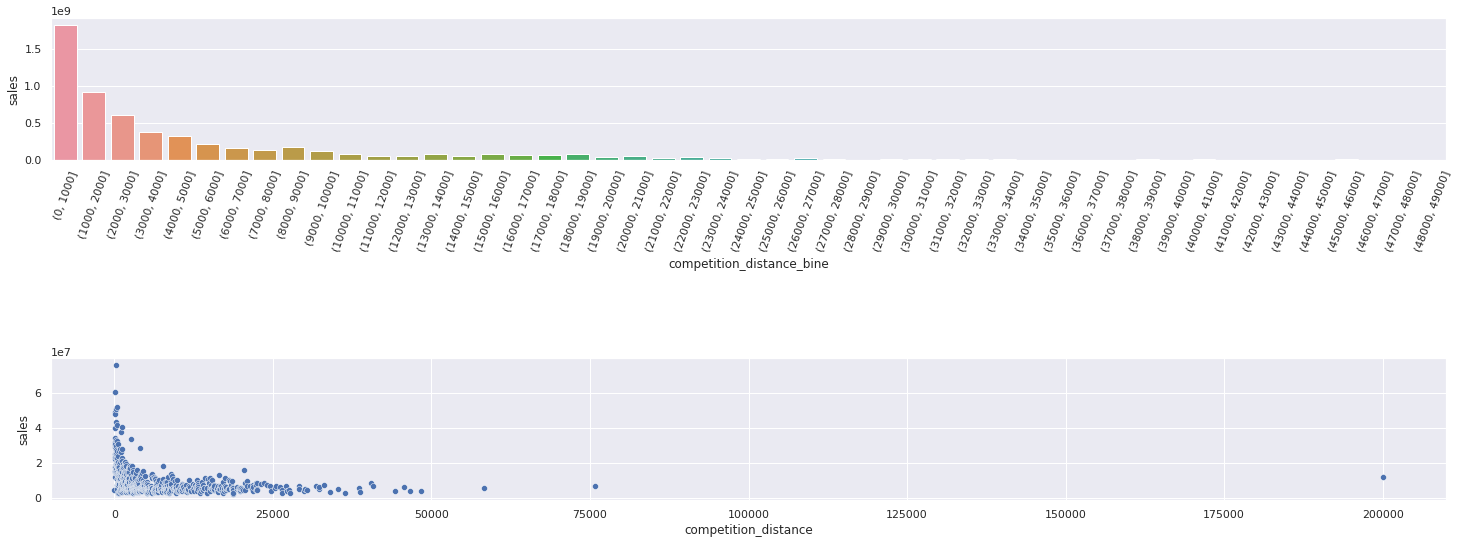

In [45]:
aux = df5
bins = list(np.arange(0, 50000, 1000))
aux['competition_distance_bine'] = pd.cut(aux['competition_distance'], bins=bins)
sales_competition = aux[['sales', 'competition_distance_bine']].groupby('competition_distance_bine').sum().reset_index()

plt.subplot(4,1,1)
sns.barplot(x= 'competition_distance_bine', y = 'sales', data=sales_competition); 
plt.xticks(rotation=70);

aux1 = aux[['sales', 'competition_distance']].groupby('competition_distance').sum().reset_index()
plt.subplot(4,1,3)
sns.scatterplot(x = 'competition_distance', y = 'sales', data = aux1);

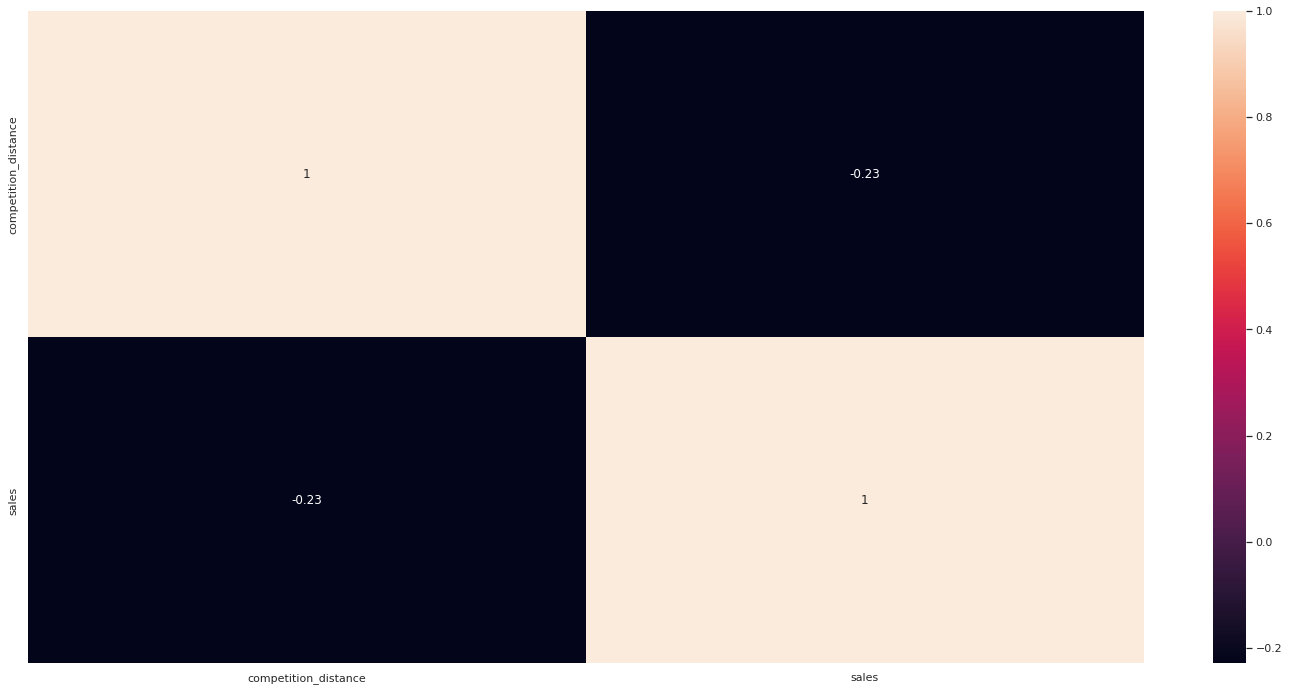

In [46]:
sns.heatmap(aux1.corr(method='pearson'), annot = True); 

- Como visto, maior a distancia dos competidores menor sao as vendas. 
- Lojas com competidores ate 1000m de distancia vendem 50% a mais que outras lojas. 

### **H4.** Lojas que entram em promocao consecutivas vendem 20% mais. 
**Falso** Lojas que entram em promocoes consecutivas vendem 10% a menos que as que entram apenas no perido regular de promocao. 

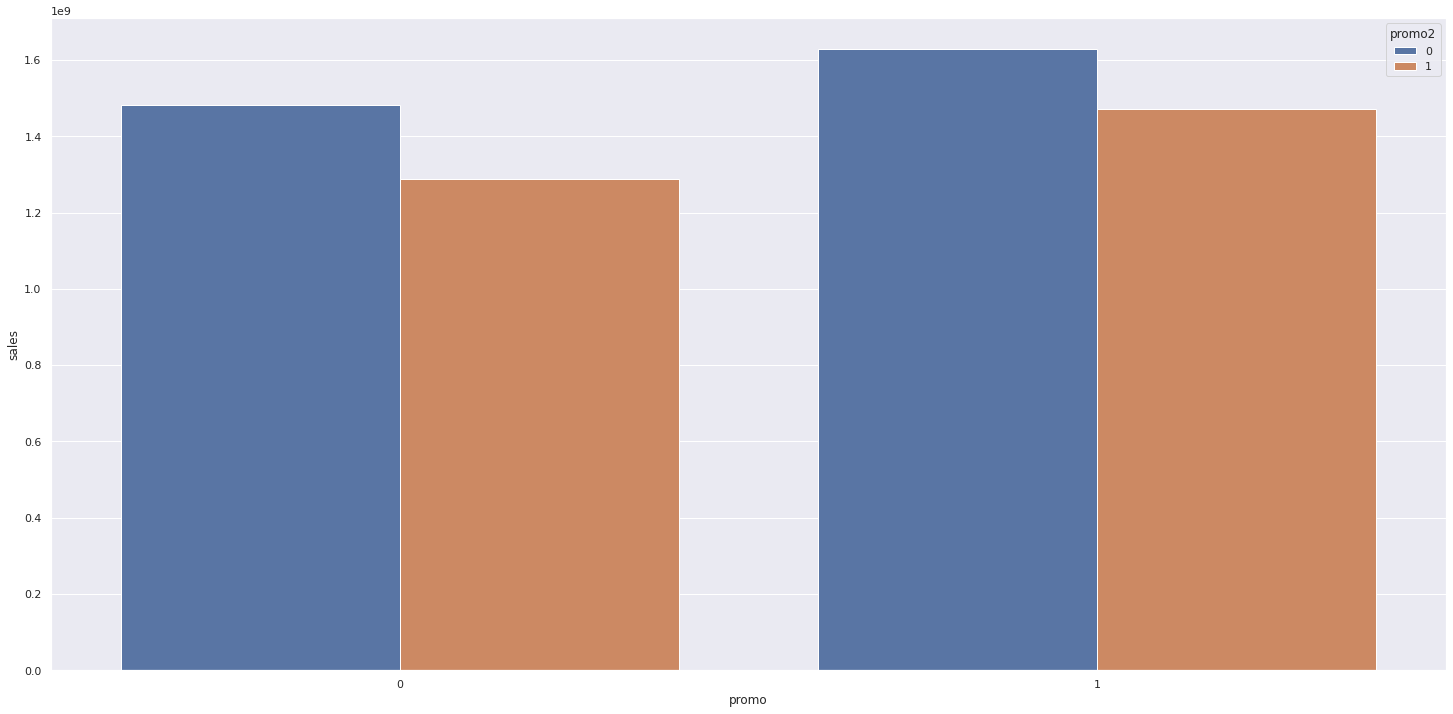

In [47]:
promo_sale = df5[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index()
sns.barplot(x = 'promo', y = 'sales', hue='promo2', data=promo_sale);

In [48]:
promo_sale

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


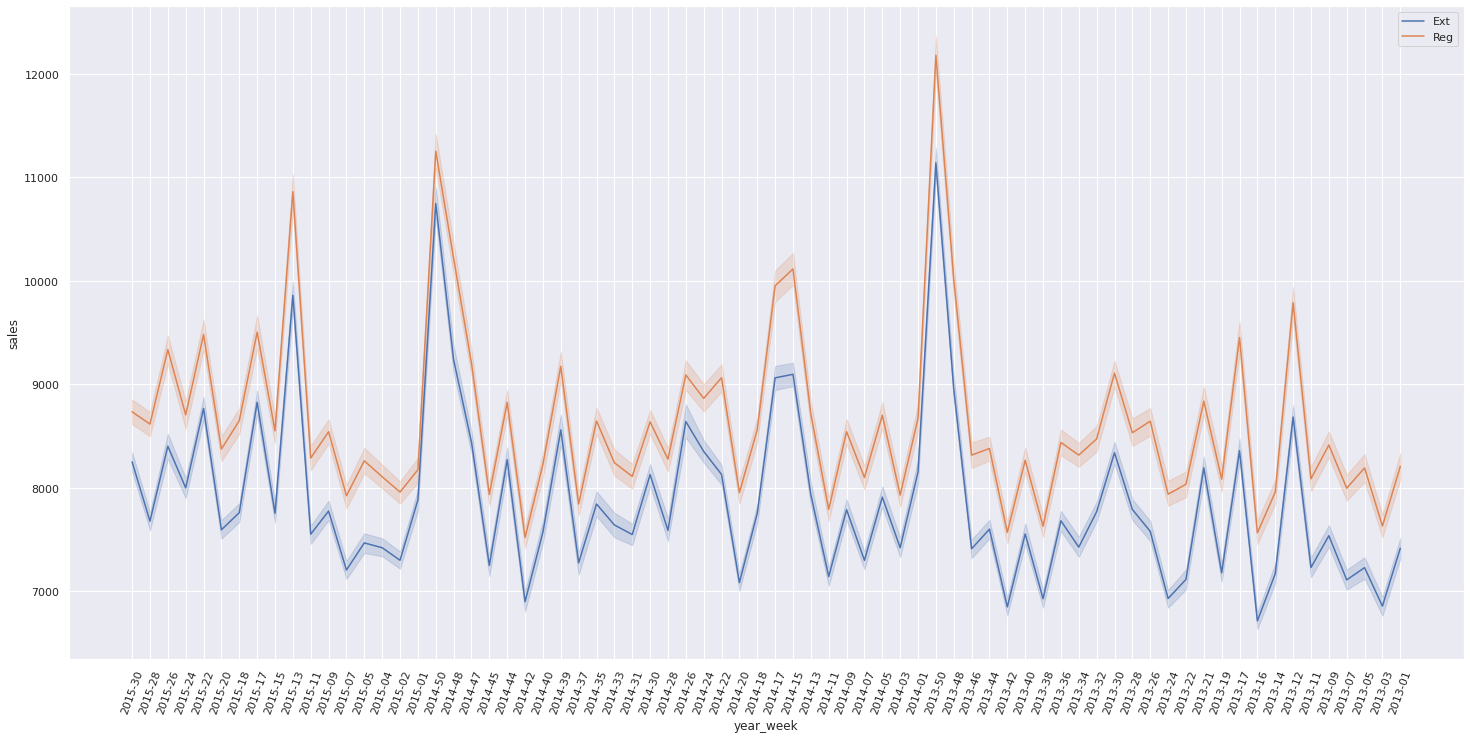

In [49]:
ext = df5[(df5['promo']==1) & (df5['promo2']==1)][['year_week', 'sales']]
reg = df5[(df5['promo']==1) & (df5['promo2']==0)][['year_week', 'sales']]


sns.lineplot(x ='year_week', y = 'sales',label = 'Ext' ,data = ext);
sns.lineplot(x ='year_week', y = 'sales',label = 'Reg', data = reg);
plt.xticks(rotation=70);

### **H5.** Lojas que ficam mais de 2 meses em promocao vendem 10% menos. 
**Falso** Lojas que ficam mais de 2 meses em promocao vendem mais durante um tempo depois suas vendas caem

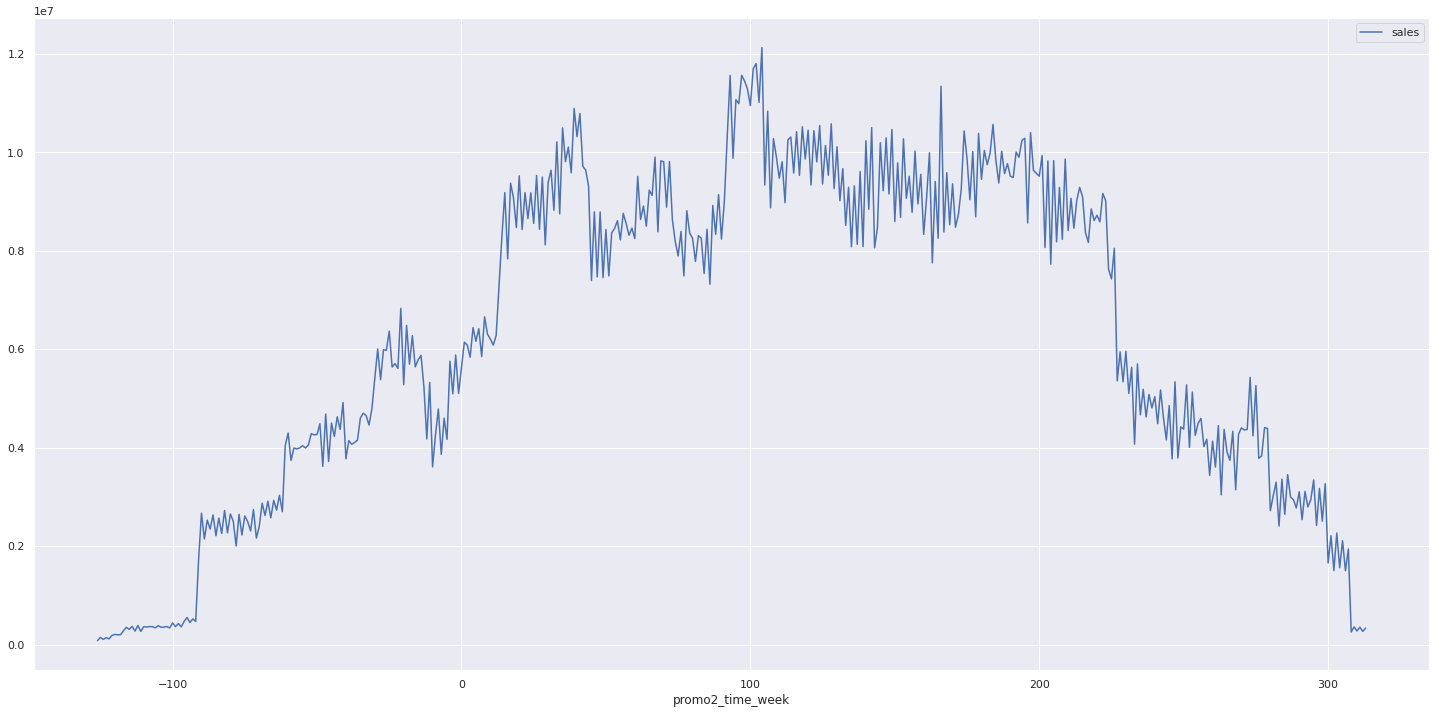

In [50]:
sales_time_promo = df5[['promo2_time_week', 'sales']]
sales_time_promo[sales_time_promo['promo2_time_week']!=0].groupby('promo2_time_week').sum().plot();

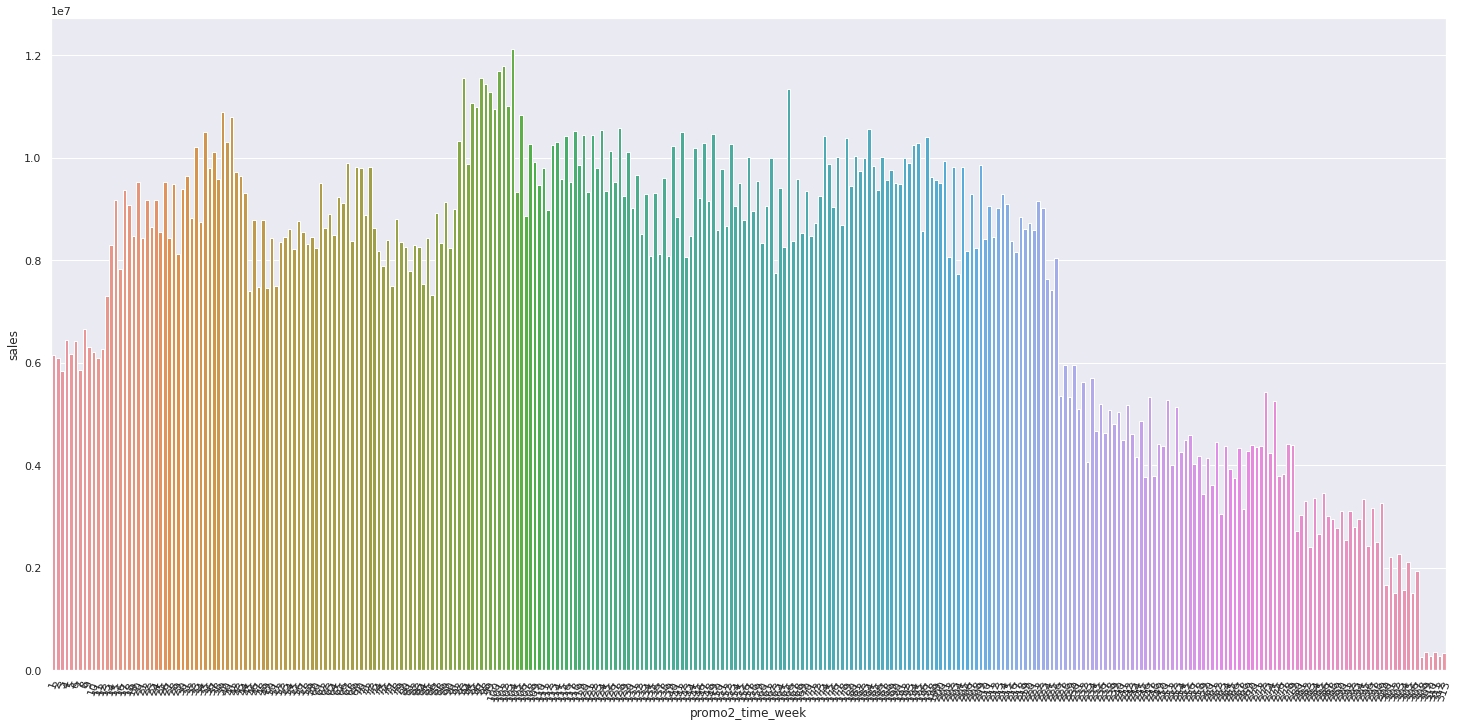

In [51]:
sales_time_promo = df5[['sales', 'promo2_time_week']]
aux = sales_time_promo.groupby('promo2_time_week').sum().reset_index()

above_time = aux[aux['promo2_time_week']> 0]
below_time = aux[aux['promo2_time_week']< 0]

sns.barplot(x='promo2_time_week', y='sales', data=above_time);
plt.xticks(rotation=70);

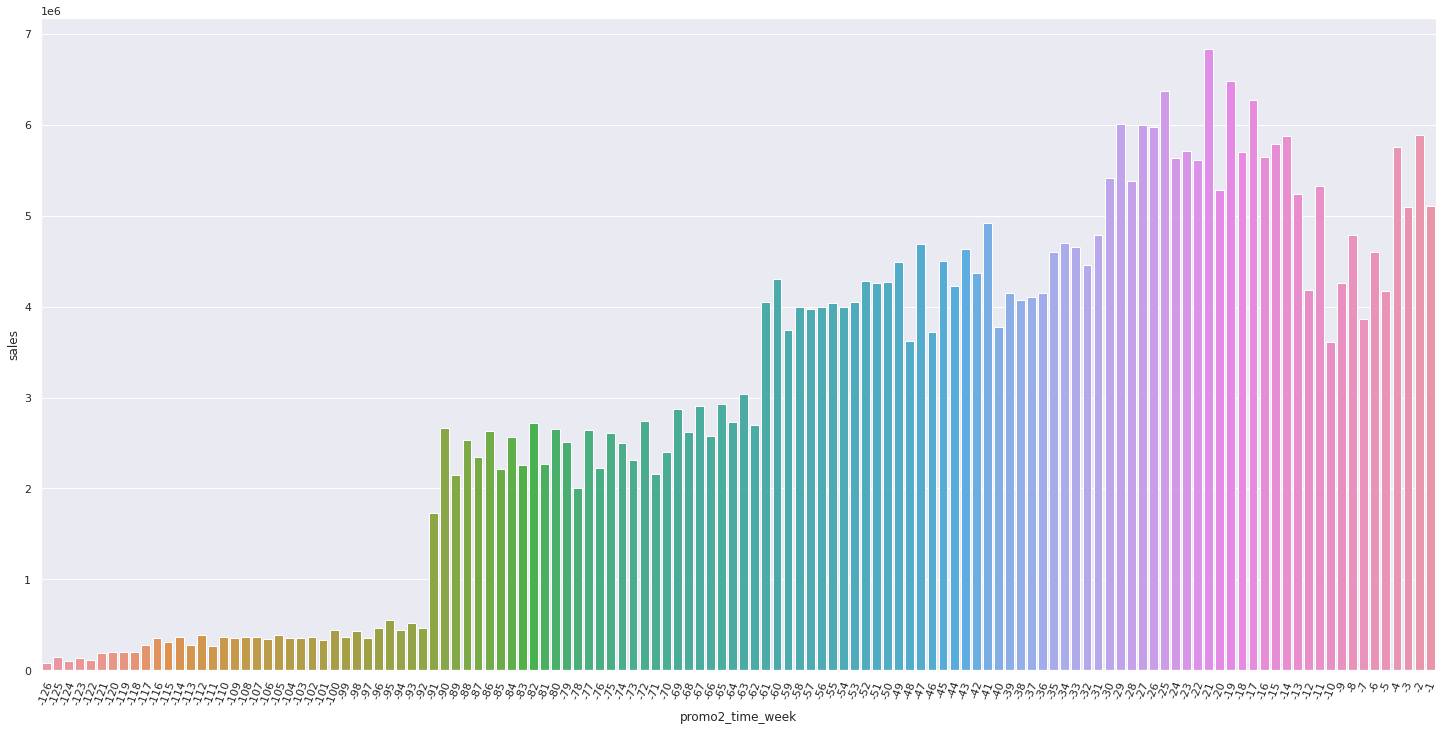

In [52]:
sns.barplot(x='promo2_time_week', y='sales', data=below_time);
plt.xticks(rotation=70);

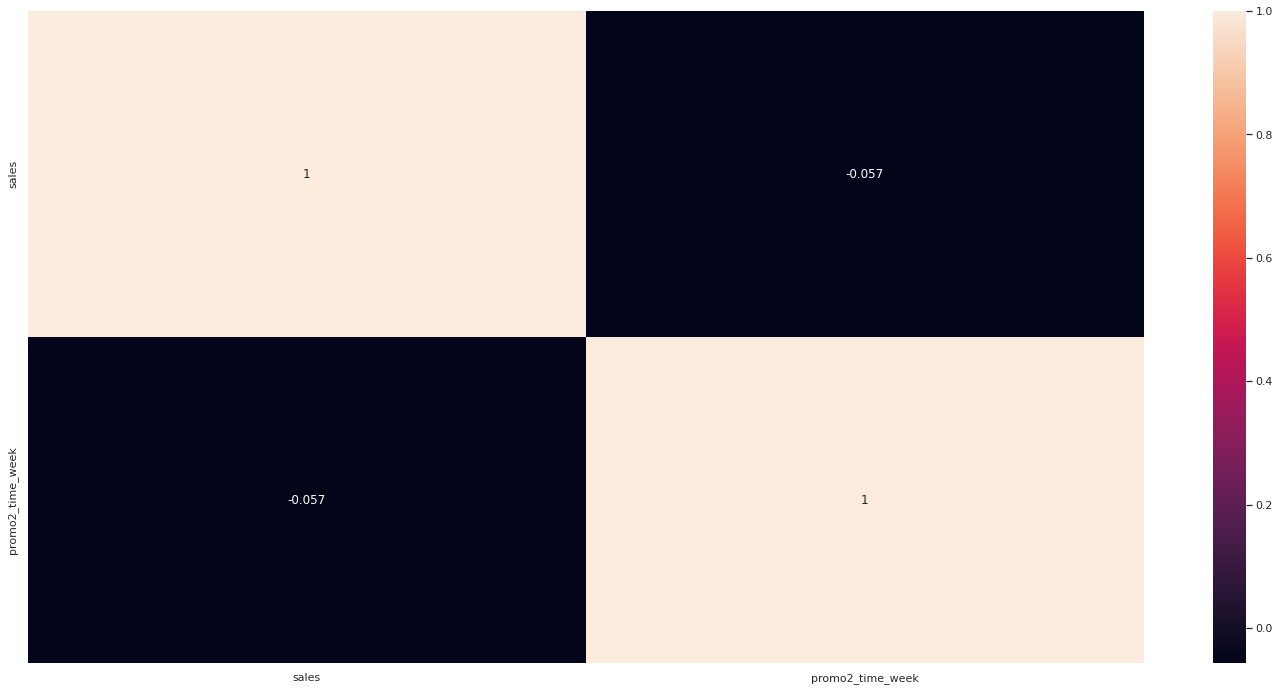

In [53]:
sns.heatmap(sales_time_promo.corr(method='pearson'), annot = True);

- Quanto mais proximo da data de promocao extendida mais a loja vende. 
- Apos o inicio das promocoes extendidas as lojas vendem regularmente e depois decaem com o tempo. 

### **H6.** Lojas vendem 15% mais no natal do que em outros feriados.
**Falso** Lojas ventem ate 88% menos no natal se comparado a outros feriados

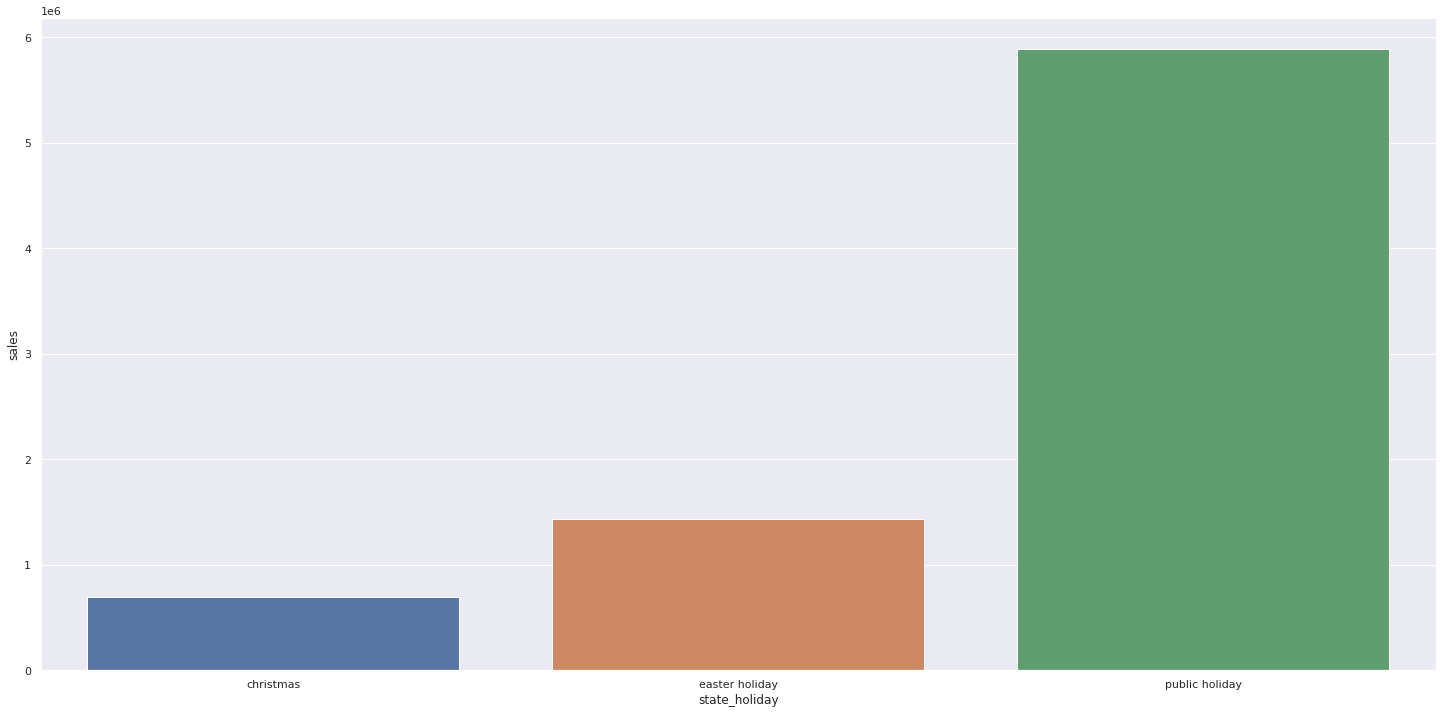

In [54]:
sales_holiday = df5[df5['state_holiday']!='regular day'][['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x = 'state_holiday', y = 'sales', data = sales_holiday);

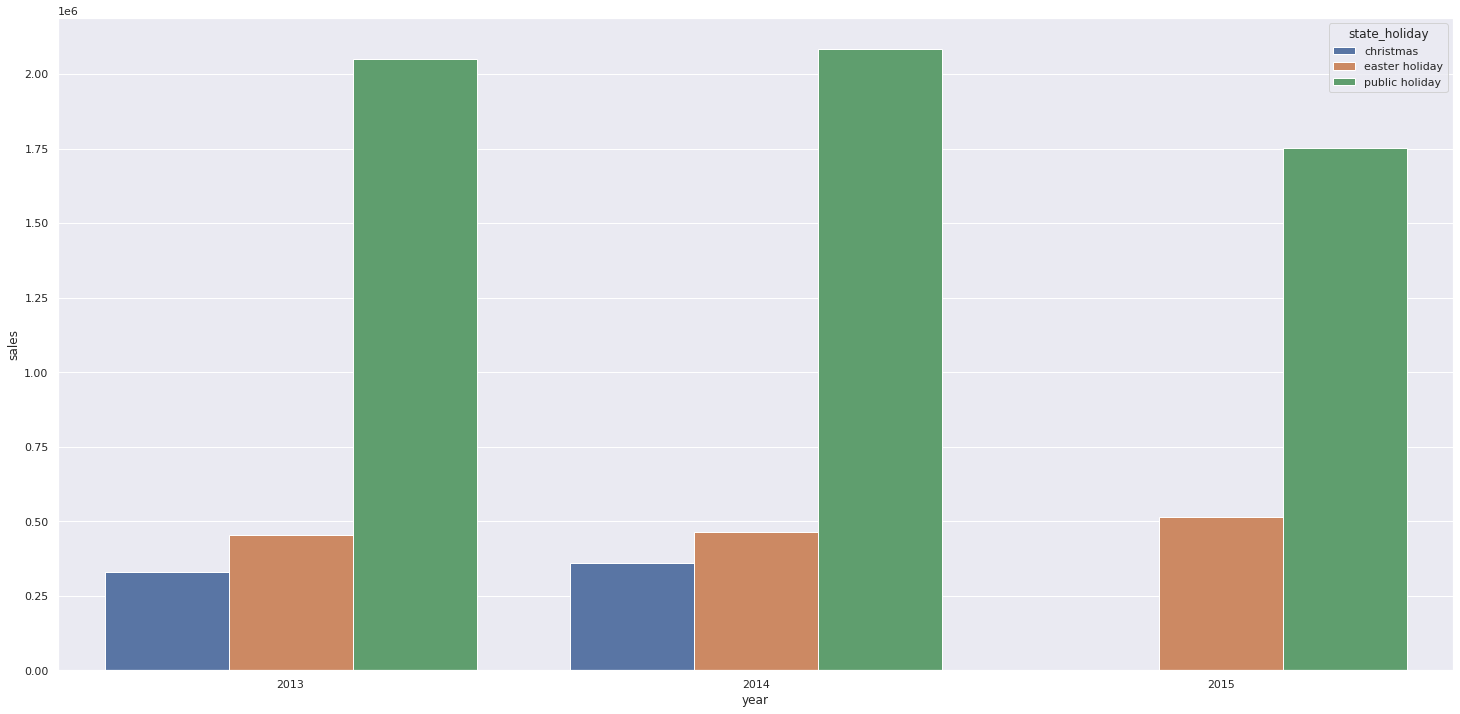

In [55]:
sales_temp_holiday = df5[df5['state_holiday']!='regular day'][['sales','state_holiday', 'year']].groupby(['year','state_holiday']).sum().reset_index()
sns.barplot(x='year', y = 'sales', hue = 'state_holiday', data = sales_temp_holiday);

- Vendas no Natal sao 88% menores que em feriados publicos
- Vendas no Natal sao 55% menores que no feriado de Pascoa
- Durante os anos as vendas em feriados publicos e pascoa aumentaram 

### **H7.** Lojas deveriam vender 5% a mais ao longo dos anos. 
**Falso** Lojas vendem 5% a menos ao longo dos anos. 

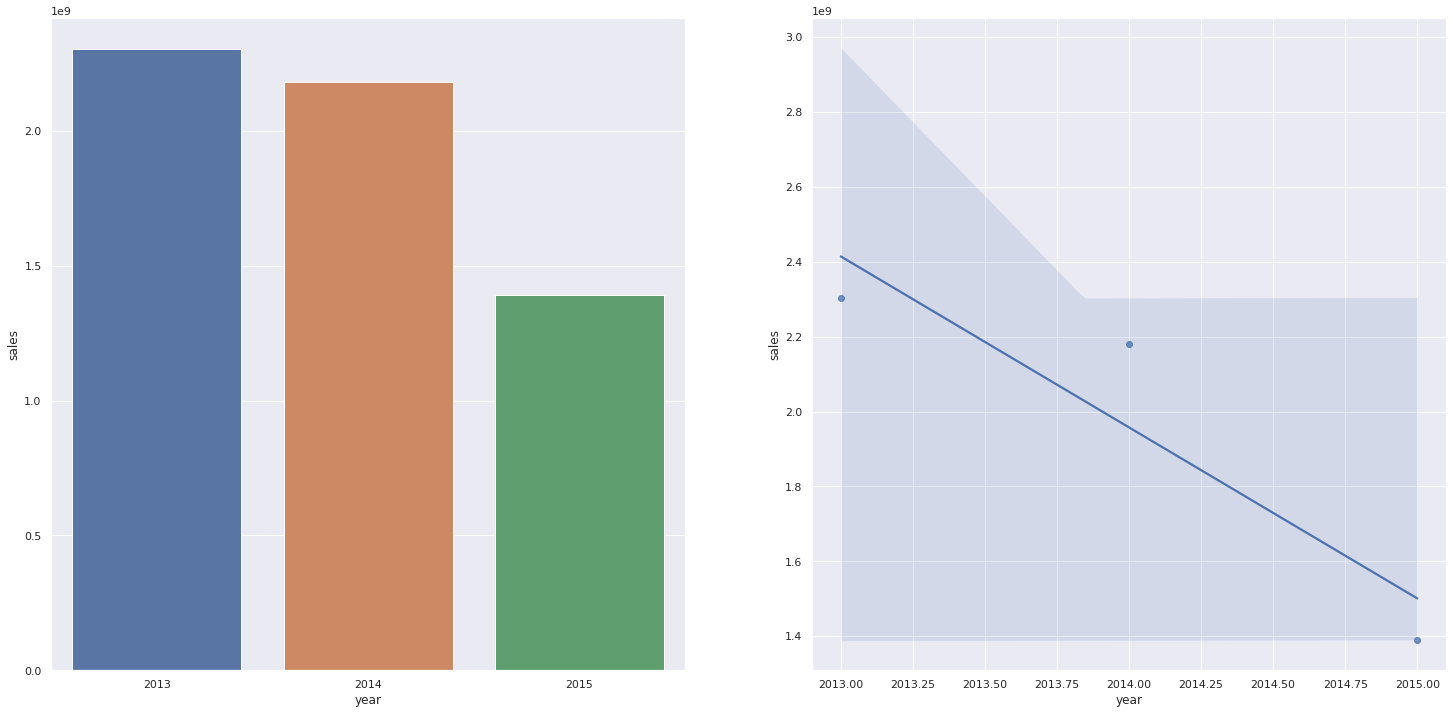

In [56]:
sales_year = df5[['year', 'sales']].groupby(['year']).sum().reset_index()

plt.subplot(1,2,1)
sns.barplot(x = 'year', y = 'sales', data = sales_year);

plt.subplot(1,2,2)
sns.regplot(x = 'year', y = 'sales', data = sales_year);

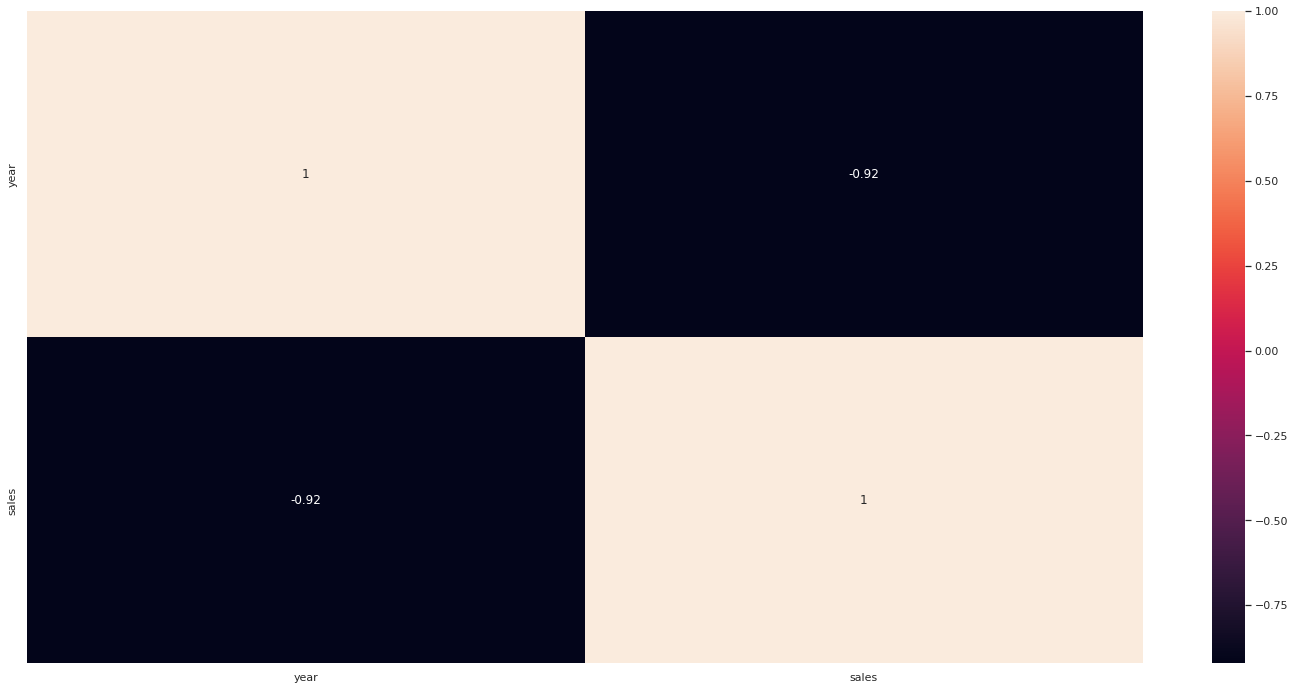

In [57]:
sns.heatmap(sales_year.corr(method='pearson'), annot = True);

In [58]:
 sales_year

,year,sales
0,2013,2302876084
1,2014,2180804896
2,2015,1389499643


- Como observado de 2013 a 2014 teve um baixa de 5% nas vendas. 
- A diminuicao nas vendas em 2015 se da pelo nao fechamento do ano, porem o mesmo da sinais de baixa nas vendas. 

### **H8.** Lojas vendem 10% a menos no final de semana. 
**Falso** Lojas vendem em media 55% menos nos finais de semana. 

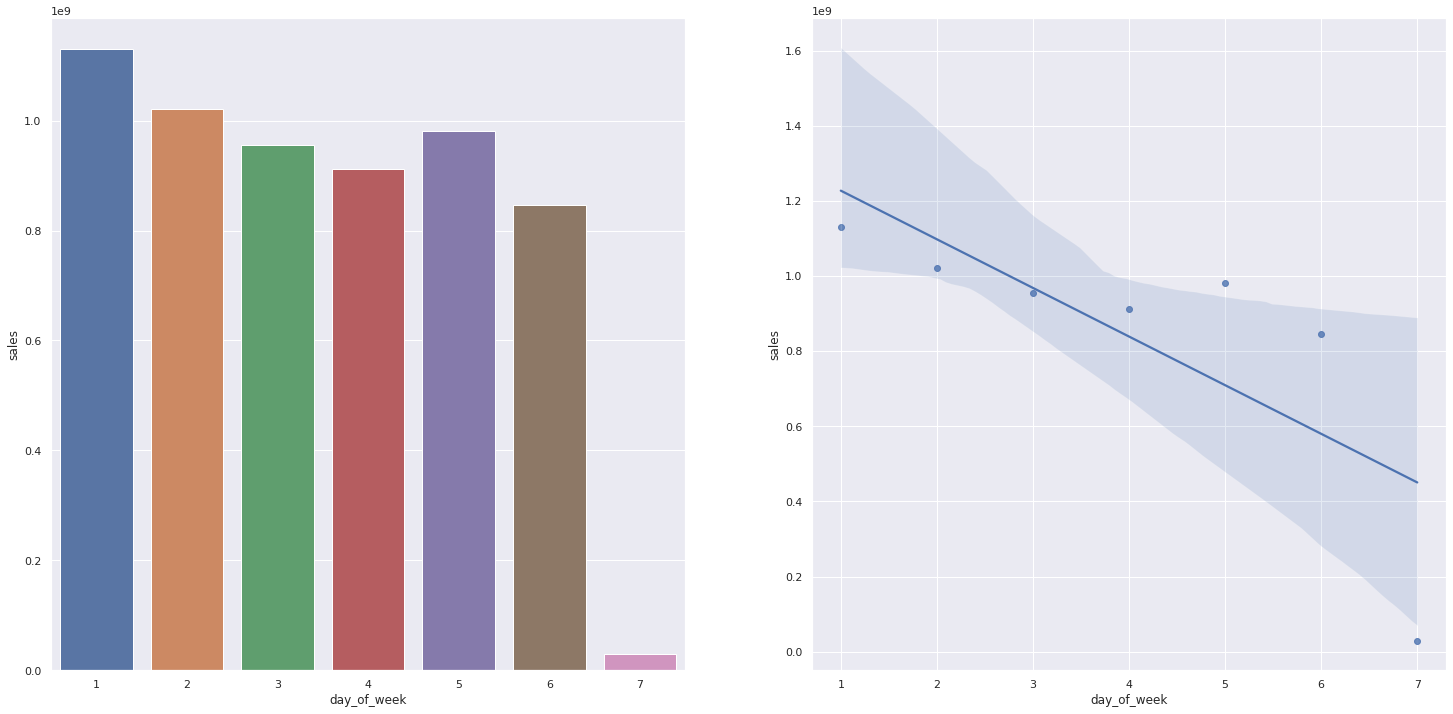

In [59]:
sales_days= df5[['day_of_week', 'sales']].groupby(['day_of_week']).sum().reset_index()

plt.subplot(1,2,1)
sns.barplot(x = 'day_of_week', y = 'sales', data = sales_days);

plt.subplot(1,2,2)
sns.regplot(x = 'day_of_week', y = 'sales', data = sales_days);

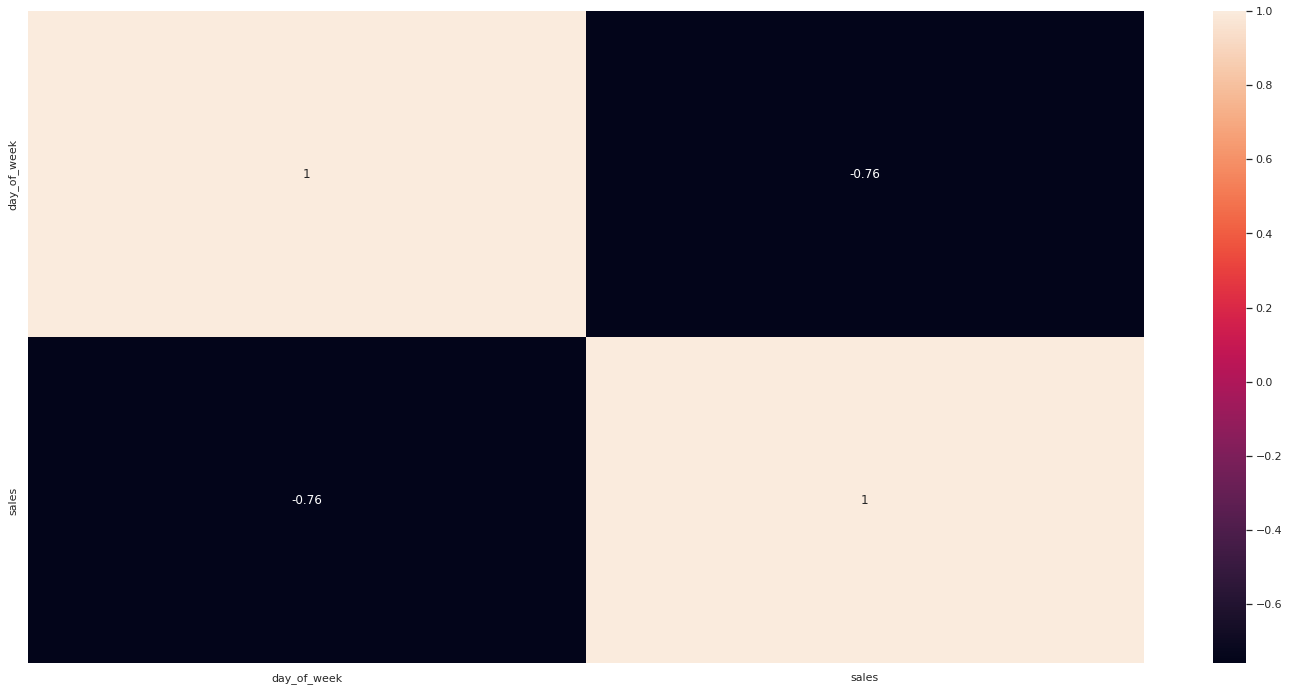

In [60]:
sns.heatmap(sales_days.corr(method='pearson'), annot = True);

- Domingo existe um comportamento diferente do padrao. 
- Em media fim de semana vende 55% menos se comparado com a media da semana. 

### **H9.** Lojas vendem 20% mais no segundo semestre do ano.
**Falso** As lojas vendem aproximadamente 28% menos no segundo semestre.

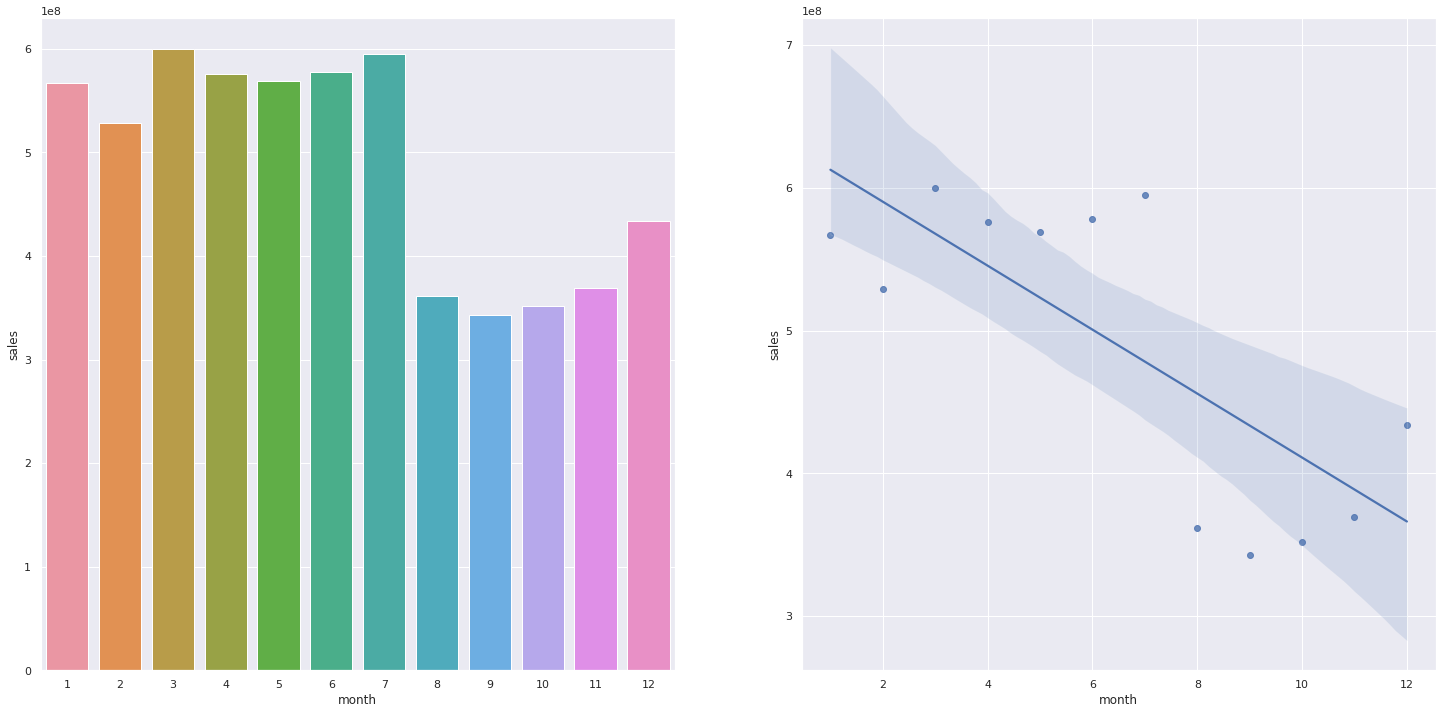

In [61]:
sales_month = df5[['month', 'sales']].groupby(['month']).sum().reset_index()

plt.subplot(1,2,1)
sns.barplot(x = 'month', y = 'sales', data = sales_month);

plt.subplot(1,2,2)
sns.regplot(x = 'month', y = 'sales', data = sales_month);

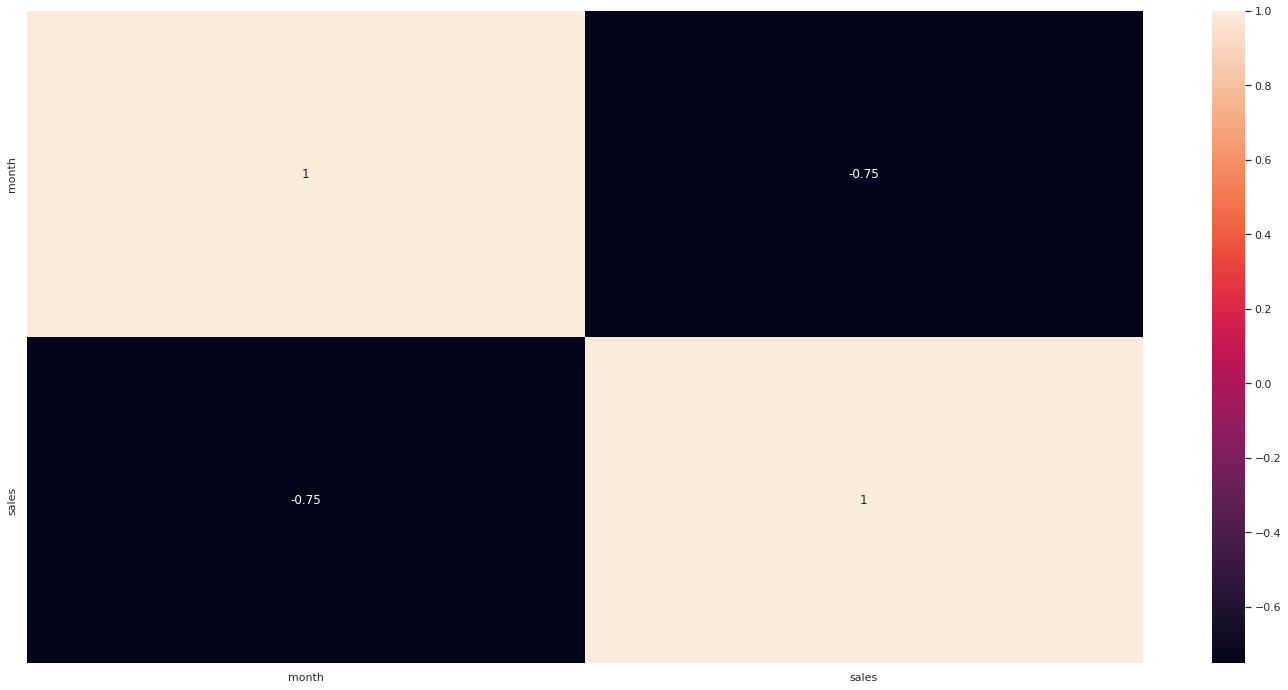

In [62]:
sns.heatmap(sales_month.corr(method='pearson'), annot = True);

In [63]:
print('segundo  semestre {}'.format(sales_month[sales_month['month']>=7]['sales'].sum()))

print('primeiro semestre {}'.format(sales_month[sales_month['month']<7]['sales'].sum()))

segundo  semestre 2454629296
primeiro semestre 3418551327


- O segundo semestre as lojas vendem 28% menos referente ao primeiro semestre 

### **H10.** Lojas vendem 15% menos durante feriados escolares.
**Verdadeiro** Lojas vendem menos deurante feriados escolares.

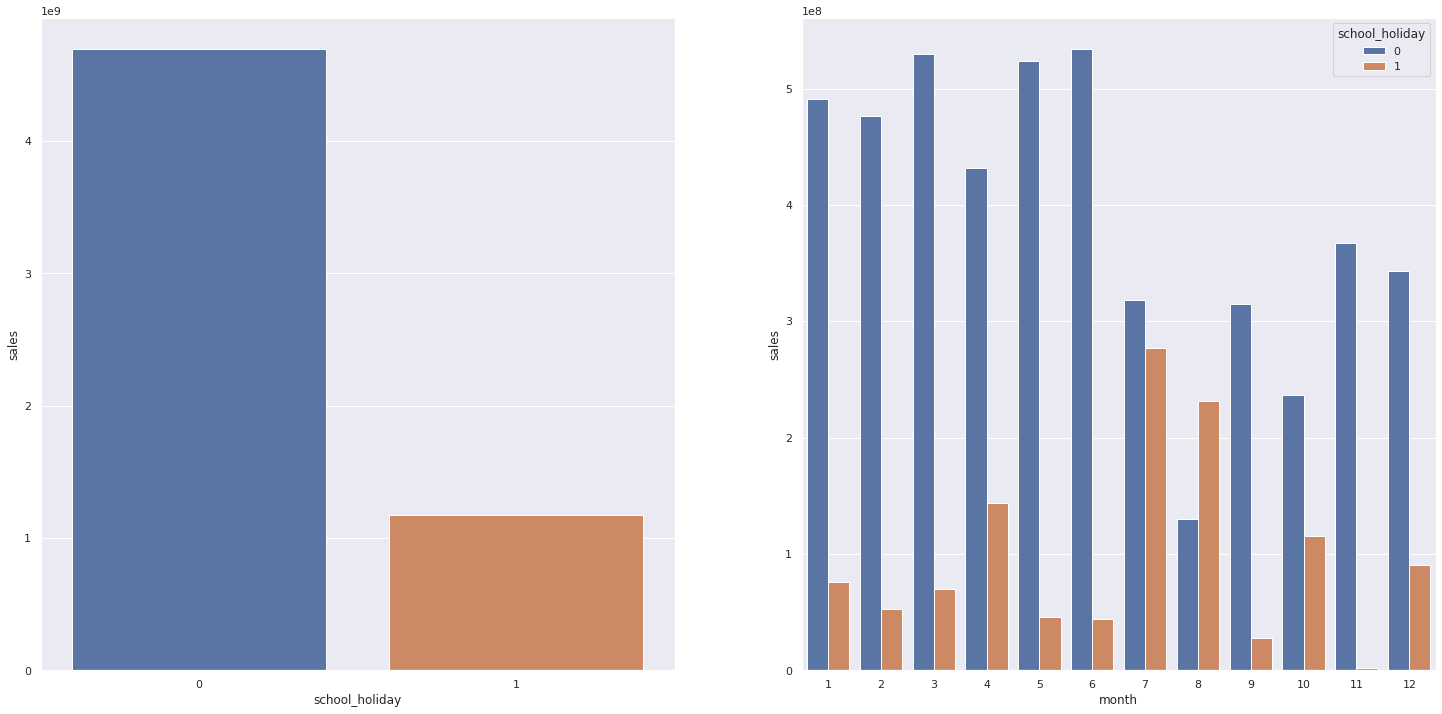

In [64]:
school_sales = df5[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()

plt.subplot(1,2,1)
sns.barplot(x = 'school_holiday', y = 'sales', data = school_sales); 

school_month_sales = df5[['school_holiday', 'sales', 'month']].groupby(['school_holiday', 'month']).sum().reset_index()
plt.subplot(1,2,2)
sns.barplot(x = 'month', y = 'sales',hue = 'school_holiday' ,data = school_month_sales); 

- Durante o mes 7 e 8 as vendas vendas em feriados escolares sao maiores 

### Resumo Hipoteses

In [65]:
tab = [['Hipotese', 'Conclusao', 'Relevancia', 'Variavel'],
       ['H1', 'Falso', 'Media', 'store_type'],
      ['H2', 'Falso', 'Baixa', 'assortment'],
      ['H3', 'Falso', 'Media', 'competition_distance'],
      ['H4', 'Falso', 'Baixa', 'promo2'],
      ['H5', 'Falso', 'Baixa', 'promo2_time_week'],
      ['H6', 'Falso', 'Media', 'state_holiday'],
      ['H7', 'Falso', 'Alta', 'year'],
      ['H8', 'Falso', 'Alta', 'day_of_week'],
      ['H9', 'Falso', 'Alta' , 'month'],
        ['H10', 'Falso', 'Baixa', 'school_holiday'],
      ]

print(tabulate(tab, headers = 'firstrow'))

Hipotese    Conclusao    Relevancia    Variavel
----------  -----------  ------------  --------------------
H1          Falso        Media         store_type
H2          Falso        Baixa         assortment
H3          Falso        Media         competition_distance
H4          Falso        Baixa         promo2
H5          Falso        Baixa         promo2_time_week
H6          Falso        Media         state_holiday
H7          Falso        Alta          year
H8          Falso        Alta          day_of_week
H9          Falso        Alta          month
H10         Falso        Baixa         school_holiday


## 5.3 Multivariada

### 5.3.1 Variaveis Numericas

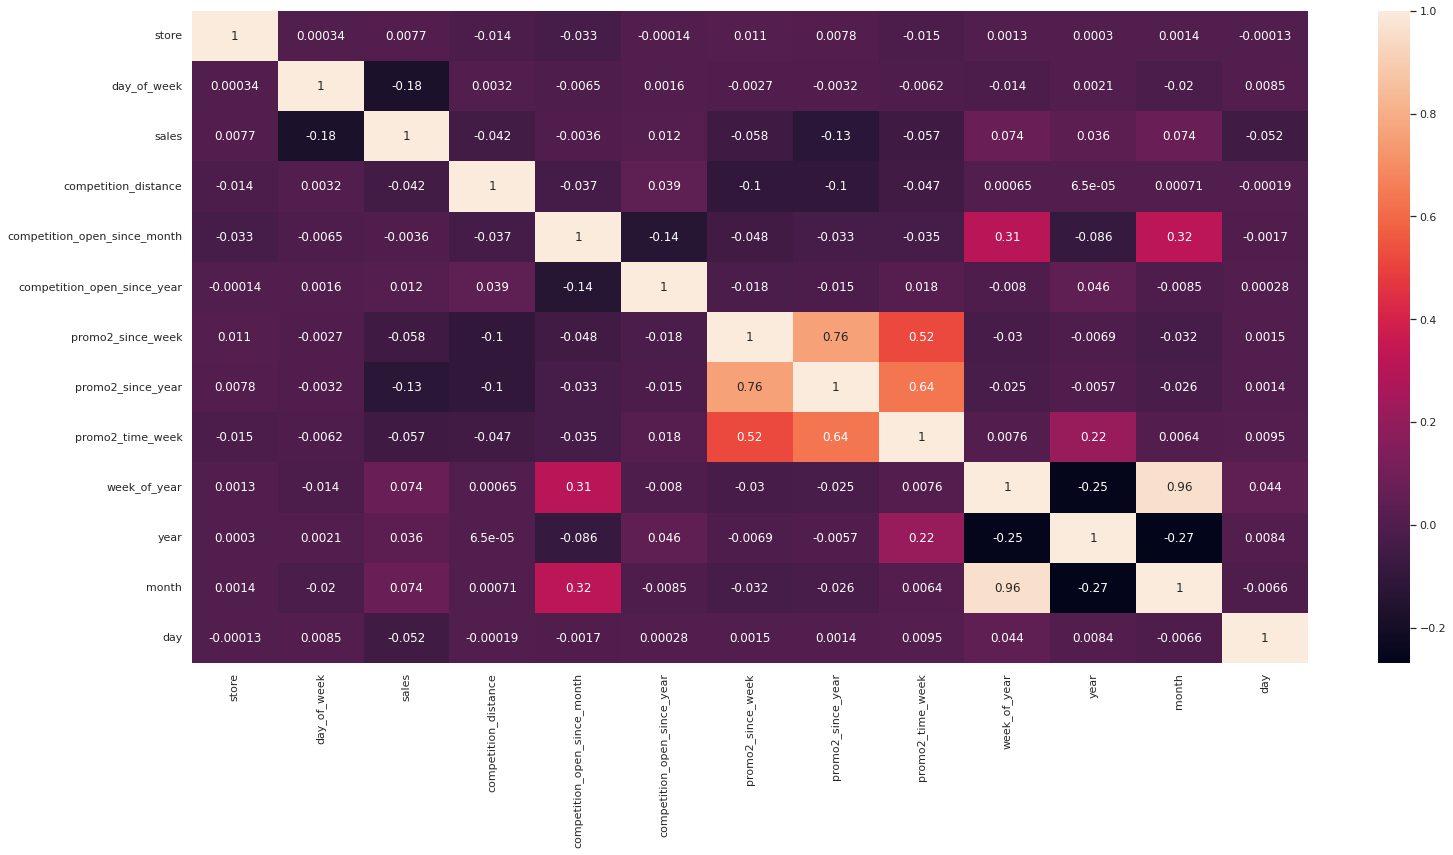

In [66]:
correlation = df5[num_attributes].corr(method='pearson')
sns.heatmap(correlation, annot = True);

### 5.3.2 Variaveis Categoricas

In [67]:
# aplica cramer v para todas as colunas categoricas 

x_columns = cat_attributes
y_columns = cat_attributes

cramer = {}

for x_col in x_columns:
    corr = []
    for y_col in y_columns:
        corr.append(cramer_v(df5.loc[:,x_col], df5.loc[:,y_col]))
        
    cramer[x_col] = corr

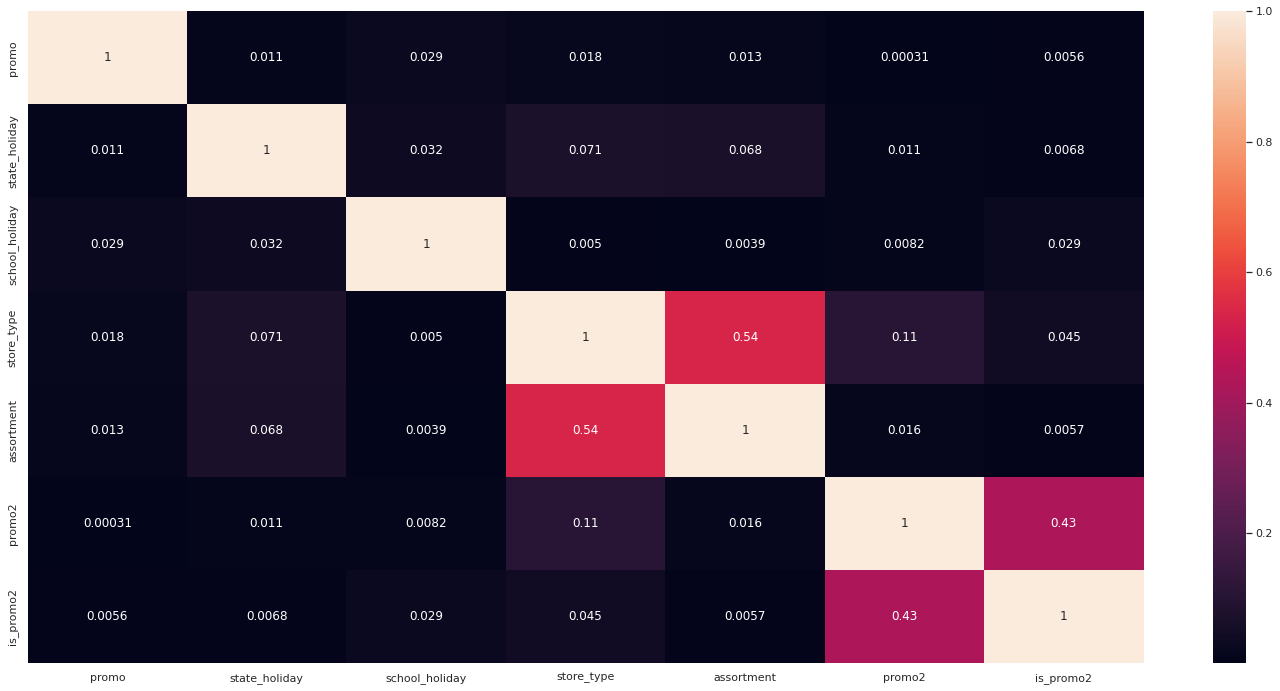

In [68]:
df_cramer_v = pd.DataFrame(cramer)
df_cramer_corr = df_cramer_v.set_index([cat_attributes])

sns.heatmap(df_cramer_corr, annot = True); 

# 6.0 Modelagem de Dados 

In [48]:
df6 = df5.copy()

## 6.1 Normalizacao

Nenhuma variavel esta apta para ser realizada a normalizacao na mesma. Pois nenhuma seguia uma destribuicao normal

## 6.2 Reescalonamento

In [49]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition_distance
df6['competition_distance'] = rs.fit_transform(df6[['competition_distance']].values)
pickle.dump(rs, open('/home/giovane/pythonProject/predicao_vendas/parameter/competition_distance_scaler.pkl', 'wb'))

# year
df6['year'] = mms.fit_transform(df6[['year']].values)
pickle.dump(mms, open('/home/giovane/pythonProject/predicao_vendas/parameter/year_scaler.pkl', 'wb'))
                     
# promo2_time_week
df6['promo2_time_week'] = mms.fit_transform(df6[['promo2_time_week']].values)
pickle.dump(mms, open('/home/giovane/pythonProject/predicao_vendas/parameter/promo2_time_week_scaler.pkl', 'wb'))

                      
# promo2_since_year
df6['promo2_since_year'] = mms.fit_transform(df6[['promo2_since_year']].values)
pickle.dump(mms, open('/home/giovane/pythonProject/predicao_vendas/parameter/promo2_since_year_scaler.pkl', 'wb'))


## 6.3 Transformacao

### 6.3.1 Encoding

In [122]:
le = LabelEncoder()

# state_holiday 
df6 = pd.get_dummies(df6, prefix= ['state_holiday'], columns=['state_holiday'])

# store_type 
df6['store_type'] = le.fit_transform(df6['store_type'])
pickle.dump(le, open('/home/giovane/pythonProject/predicao_vendas/parameter/store_type_encoding.pkl', 'wb'))


# assortment
assortment_dict = {'basic' : 1, 'extra' : 2 , 'extended' : 3}
df6['assortment'] = df6['assortment'].map(assortment_dict)

### 6.3.2 Transformacao de Grandeza Variavel Resposta

In [72]:
df6['sales'] = np.log1p(df6['sales'])

### 6.3.3 Transformacao de Natureza

In [73]:
# month
df6['month_sin'] = df6['month'].apply(lambda x: np.sin(x * (2. * np.pi/12)))
df6['month_cos'] = df6['month'].apply(lambda x: np.cos(x * (2. * np.pi/12)))


# day
df6['day_sin'] = df6['day'].apply(lambda x: np.sin(x * (2. * np.pi/30)))
df6['day_cos'] = df6['day'].apply(lambda x: np.cos(x * (2. * np.pi/30)))

# week_of_year
df6['week_of_year_sin'] = df6['week_of_year'].apply(lambda x: np.sin(x * (2. * np.pi/52)))
df6['week_of_year_cos'] = df6['week_of_year'].apply(lambda x: np.cos(x * (2. * np.pi/52)))

# day_of_week
df6['day_of_week_sin'] = df6['day_of_week'].apply(lambda x: np.sin(x * (2. * np.pi/7)))
df6['day_of_week_cos'] = df6['day_of_week'].apply(lambda x: np.cos(x * (2. * np.pi/7)))

# competition_open_since_month
df6['competition_open_since_month_sin'] = df6['competition_open_since_month'].apply(lambda x: np.sin(x * (2. * np.pi/12)))
df6['competition_open_since_month_cos'] = df6['competition_open_since_month'].apply(lambda x: np.cos(x * (2. * np.pi/12)))

# promo2_since_week
df6['promo2_since_week_sin'] = df6['promo2_since_week'].apply(lambda x: np.sin(x * (2. * np.pi/52)))
df6['promo2_since_week_cos'] = df6['promo2_since_week'].apply(lambda x: np.cos(x * (2. * np.pi/52)))

In [74]:
df6

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo2,year,month,day,week_of_year,year_week,promo2_since,promo2_time_week,competition_distance_bine,state_holiday_christmas,state_holiday_easter holiday,state_holiday_public holiday,state_holiday_regular day,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos,day_of_week_sin,day_of_week_cos,competition_open_since_month_sin,competition_open_since_month_cos,promo2_since_week_sin,promo2_since_week_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,1270.0,9,2008,0,0,0,0,2015,7,31,31,2015-30,0,0,"(1000, 2000]",0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521,-1.000000e+00,-1.836970e-16,0.000000,1.000000e+00
1,2,5,2015-07-31,8.710290,1,1,0,1,570.0,11,2007,1,13,2010,1,2015,7,31,31,2015-30,2010-03-22 00:00:00,279,"(0, 1000]",0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521,-5.000000e-01,8.660254e-01,1.000000,6.123234e-17
2,3,5,2015-07-31,9.025816,1,1,0,1,14130.0,12,2006,1,14,2011,1,2015,7,31,31,2015-30,2011-03-28 00:00:00,226,"(14000, 15000]",0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521,-2.449294e-16,1.000000e+00,0.992709,-1.205367e-01
3,4,5,2015-07-31,9.546527,1,1,2,3,620.0,9,2009,0,0,0,0,2015,7,31,31,2015-30,0,0,"(0, 1000]",0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521,-1.000000e+00,-1.836970e-16,0.000000,1.000000e+00
4,5,5,2015-07-31,8.481151,1,1,0,1,29910.0,4,2015,0,0,0,0,2015,7,31,31,2015-30,0,0,"(29000, 30000]",0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521,8.660254e-01,-5.000000e-01,0.000000,1.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1016776,682,2,2013-01-01,8.124447,0,1,1,1,150.0,9,2006,0,0,0,0,2013,1,1,1,2013-00,0,0,"(0, 1000]",0,0,1,0,0.5,0.866025,0.207912,0.978148,0.120537,0.992709,0.974928,-0.222521,-1.000000e+00,-1.836970e-16,0.000000,1.000000e+00
1016827,733,2,2013-01-01,9.284148,0,1,1,2,860.0,10,1999,0,0,0,0,2013,1,1,1,2013-00,0,0,"(0, 1000]",0,0,1,0,0.5,0.866025,0.207912,0.978148,0.120537,0.992709,0.974928,-0.222521,-8.660254e-01,5.000000e-01,0.000000,1.000000e+00
1016863,769,2,2013-01-01,8.524367,0,1,1,2,840.0,1,2013,1,48,2012,1,2013,1,1,1,2013-00,2012-11-19 00:00:00,6,"(0, 1000]",0,0,1,0,0.5,0.866025,0.207912,0.978148,0.120537,0.992709,0.974928,-0.222521,5.000000e-01,8.660254e-01,-0.464723,8.854560e-01
1017042,948,2,2013-01-01,8.410053,0,1,1,2,1430.0,1,2013,0,0,0,0,2013,1,1,1,2013-00,0,0,"(1000, 2000]",0,0,1,0,0.5,0.866025,0.207912,0.978148,0.120537,0.992709,0.974928,-0.222521,5.000000e-01,8.660254e-01,0.000000,1.000000e+00


# 7.0 Selecao de Variaveis 

In [75]:
df7 = df6.copy()

## 7.1 Split Treino e Teste Dataset 

In [76]:
# removendo colunas que derivam
cols_drop = ['competition_distance_bine', 'day', 'week_of_year', 'month', 'day_of_week', 'promo2_since_week', 'promo2_since', 'year_week']
df7 = df7.drop(cols_drop, axis=1)

In [77]:
df7[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days =6*7)

Timestamp('2015-06-19 00:00:00')

In [78]:
# dataset de treino
x_train = df7[df7['date'] < '2015-06-19']
y_train  = x_train['sales']

# dataset de teste
x_test = df7[df7['date'] >= '2015-06-19']
y_test  = x_test['sales']


## 7.2 Selecionador de Variaveis - Boruta 

In [79]:
x_train_n = x_train.drop(['date', 'sales'], axis=1).values
y_train_n = y_train.values

In [80]:
# definindo RandomForest
rf = RandomForestRegressor(n_jobs = 1)

# defininfo atributos do boruta
# boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(x_train_n, y_train_n)

In [81]:
# boruta_cols_selected = boruta.support_.tolist()

# colunas selecionadas pelo boruta
# x_train_fs = x_train.drop(['date', 'sales'], axis=1)
# cols_selected = x_train_fs.iloc[:, boruta_cols_selected].columns.tolist()

# colunas nao selecionadas pelo boruta 
# cols_not_selected = np.setdiff1d(x_train_fs.columns, cols_selected)

## 7.3 Selecao Manual

In [82]:
cols_selected_boruta = ['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_year',
 'promo2',
 'promo2_since_year',
 'promo2_time_week',
 'month_cos', 
 'month_sin',
 'day_sin',
 'day_cos',
 'week_of_year_cos',
 'week_of_year_sin',
 'day_of_week_sin',
 'day_of_week_cos',
 'competition_open_since_month'
 ]

cols_not_selected_boruta = ['is_promo2', 'school_holiday',
       'state_holiday_christmas', 'state_holiday_easter holiday',
       'state_holiday_public holiday', 'state_holiday_regular day','year']

# colunas para adicionar 
cols_add = ['date', 'sales']

#atributos finais 
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(cols_add)

In [83]:
cols_selected_boruta

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_year',
 'promo2',
 'promo2_since_year',
 'promo2_time_week',
 'month_cos',
 'month_sin',
 'day_sin',
 'day_cos',
 'week_of_year_cos',
 'week_of_year_sin',
 'day_of_week_sin',
 'day_of_week_cos',
 'competition_open_since_month']

# 8.0 Modelagem Machine Learning 

In [84]:
x_train01 = x_train[cols_selected_boruta]
x_test01 = x_test[cols_selected_boruta]

x_training = x_train[cols_selected_boruta_full]

## 8.1 Modelo Media 

In [85]:
aux1 = x_test01.copy()
aux1['sales'] = y_test.copy()

#predicao 
aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename(columns = {'sales': 'prediction'})
aux1 = pd.merge(aux1, aux2, how = 'left', on = 'store')
yhat_baseline = aux1['prediction']

In [86]:
#performance 
baseline_result = ml_error('Modelo de Media', np.expm1(y_test), np.expm1(yhat_baseline))
baseline_result

,Nome modelo,MAE,MAPE,RMSE
0,Modelo de Media,1354.800353,0.455051,1835.135542


## 8.2 Modelo Regressao Linear 

In [87]:
#model
lr = LinearRegression().fit(x_train01, y_train)

#predicao 
yhat_lr = lr.predict(x_test01)

#performance
lr_result = ml_error('Regressao Linear', np.expm1(y_test), np.expm1(yhat_lr))


In [88]:
lr_result

,Nome modelo,MAE,MAPE,RMSE
0,Regressao Linear,1876.13728,0.28554,2721.894433


De acordo com o RMSE o modelo de regressao linar é pior que o modelo de media e que os dados podem ter um comportamento complexo (nao linear), logo modelos lineares nao apremderam o comportamento. 

### 8.2.1 Modelo Regressao Linear - Cross Validation

In [89]:
lr_result_cv = cross_validation(x_training, 5, 'Regressao Linear', lr, verbose=False)

lr_result_cv 

,Modelo,MAE CV,MAPE CV,RMSE CV
0,Regressao Linear,2110.5 +/- 348.59,0.3 +/- 0.01,3024.98 +/- 534.86


## 8.3 Modelo Regressao Linear Regularizada - Lasso

In [90]:
#model
lr_lasso = Lasso(alpha = 0.01).fit(x_train01, y_train)

#predicao 
yhat_lr_lasso = lr_lasso.predict(x_test01)

#performance
lr_lasso_result = ml_error('Regressao Linear Lasso', np.expm1(y_test), np.expm1(yhat_lr_lasso))

lr_lasso_result

,Nome modelo,MAE,MAPE,RMSE
0,Regressao Linear Lasso,1897.601806,0.290899,2752.229581


### 8.3.1 Modelo Regressao Linear Regularizada - Lasso - Cross Validation

In [91]:
lrl_result_cv = cross_validation(x_training, 5, 'Regressao Linear Lasso', lr_lasso, verbose=False)
lrl_result_cv

,Modelo,MAE CV,MAPE CV,RMSE CV
0,Regressao Linear Lasso,2119.61 +/- 359.87,0.3 +/- 0.01,3046.17 +/- 541.66


## 8.4 Modelo Random Forest 

In [92]:
#modelo 
#rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=43).fit(x_train01, y_train)

#predicao
#yhat_rf = rf.predict(x_test01)

#performance 
#rf_result = ml_error('Random Forest', np.expm1(y_test), np.expm1(yhat_rf))

#rf_result

### 8.4.1 Modelo Random Forest - Cross Validation 

In [93]:
#rf_result_cv = cross_validation(x_training, 5, 'Random Forest', rf, verbose=True)
#rf_result_cv

## 8.5 XGBoost

In [94]:
#modelo
#xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, eta = 0.01, 
                             #max_depth = 10, subsample = 0.7).fit(x_train01, y_train)

#predicao 
#yhat_xgb = xgb_model.predict(x_test01)

#performance 
#xgb_result = ml_error('XGBoost', np.expm1(y_test), np.expm1(yhat_xgb))
#xgb_result

### 8.5.1 XGBoost - Cross Validation

In [95]:
#xgb_result_cv = cross_validation(x_training, 5, 'XGB', xgb_model, verbose=True)
#xgb_result_cv

## 8.6 Comparacao Performance 

### 8.6.1 Performance Unica

In [96]:
#modelling_result = pd.concat( [baseline_result, lr_result, lr_lasso_result,rf_result,xgb_result] )
#modelling_result.sort_values('RMSE')

Podemos ver que o fenomeno analisado se trata de um fenomeno complexo, logo modelos lineares terao baixa performance.

### 8.6.1 Performance Real - Cross Validation

In [97]:
#modelling_result_cv = pd.concat( [lr_result_cv, lrl_result_cv,rf_result_cv,xgb_result_cv] )
#modelling_result_cv.sort_values('RMSE CV')

# 9.0 Hyperparameter Fine Tuning 

In [98]:
x_train01 = x_train[cols_selected_boruta]
x_test01 = x_test[cols_selected_boruta]

x_training = x_train[cols_selected_boruta_full]

## 9.1 Random Search 

In [99]:
param   = {
    'n_estimators' : [1500, 1700, 2500, 3000, 3500],
    'eta': [0.01, 0.03],
    'max_depth': [3, 5, 9],
    'subsample': [0.1, 0.5, 0.7],
    'colsample_bytree': [0.3, 0.7, 0.9],
    'min_child_weight': [3, 8, 13]    
}

MAX_EVAL = 10

In [100]:
#final_result = pd.DataFrame()

#for i in range(MAX_EVAL):
    #escolher o valor para os parametros randomicamente
    #hp = hp = {k : random.sample(v, 1)[0] for k, v in param.items()}
    #print(hp)
    
    #modelo
    #xgb_model = xgb.XGBRFRegressor(objective='reg:squarederror', 
                                   #n_estimators=hp['n_estimators'], 
                                   #eta = hp['eta'], 
                                   #max_depth = hp['max_depth'], 
                                   #subsample = hp['subsample'],
                                   #colsample_bytree = hp['colsample_bytree'],
                                   #min_child_weight = hp['min_child_weight'])

    #performance 
    #result = cross_validation(x_training, 5, 'XGB', xgb_model, verbose=False)
    #final_result = pd.concat([final_result, result])
    
#final_result

## 9.2 Modelo Final

In [101]:
param_tuned = {
    'n_estimators': 3000,
    'eta': 0.03,
    'max_depth': 5,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'min_child_weight': 3 
        }

In [102]:
# model
model_xgb_tuned = xgb.XGBRegressor( objective='reg:squarederror',
                                    n_estimators=param_tuned['n_estimators'], 
                                    eta=param_tuned['eta'], 
                                    max_depth=param_tuned['max_depth'], 
                                    subsample=param_tuned['subsample'],
                                    colsample_bytree=param_tuned['colsample_bytree'],
                                    min_child_weight=param_tuned['min_child_weight'] ).fit( x_train01, y_train )

# prediction
yhat_xgb_tuned = model_xgb_tuned.predict( x_test01 )

# performance
xgb_result_tuned = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb_tuned ) )
xgb_result_tuned

,Nome modelo,MAE,MAPE,RMSE
0,XGBoost Regressor,774.99804,0.114456,1119.643702


In [103]:
mpe =  mean_percentage_error(np.expm1(y_test), np.expm1(yhat_xgb_tuned))
mpe

-0.0019386764631073282

# 10.0 Traducao e Interpretacao do Erro

In [105]:
df10 = x_test[cols_selected_boruta_full].copy()

#rescala valor de vendas
df10['sales'] = np.expm1(df10['sales'])
df10['predictions'] = np.expm1(yhat_xgb_tuned)

## 10.1 Performance de Negocio

In [106]:
#somas das predicoes 
store_prediction = df10[['store', 'predictions']].groupby('store').sum().reset_index()

#MAE e MAPE por loja 
store_mae = df10[['store','sales', 'predictions']].groupby('store').apply(lambda x : mean_absolute_error(x['sales'],
                                                                                                        x['predictions'])).reset_index().rename(columns = {0: 'MAE'})

store_mape = df10[['store','sales', 'predictions']].groupby('store').apply(lambda x : mean_absolute_percentage_error(x['sales'],
                                                                                                        x['predictions'])).reset_index().rename(columns = {0: 'MAPE'})

#merge 
aux1 = pd.merge(store_mae, store_mape, how = 'inner', on = 'store')
store_performance = pd.merge(store_prediction, aux1, how = 'inner', on ='store')

In [107]:
#cenarios 
store_performance['worst_scenario'] = store_performance['predictions'] - (store_performance['MAPE'] * store_performance['predictions'])
store_performance['best_scenario'] = store_performance['predictions'] + (store_performance['MAPE'] * store_performance['predictions'])

#ordenando colunas
store_performance = store_performance[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

In [108]:
store_performance.sort_values('MAPE', ascending=False)

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,104899.890625,43094.806743,166704.974507,3416.403385,0.589182
908,909,214204.234375,102722.196332,325686.272418,8035.257728,0.520447
838,839,182163.078125,112074.378319,252251.777931,1176.056311,0.384758
769,770,228993.390625,148373.701608,309613.079642,1443.226285,0.352061
285,286,170853.468750,110977.422120,230729.515380,946.737014,0.350453
...,...,...,...,...,...,...
666,667,309233.843750,291738.470689,326729.216811,526.004896,0.056577
357,358,353938.500000,334033.997676,373843.002324,550.109481,0.056237
741,742,298217.500000,281486.984578,314948.015422,464.913284,0.056102
762,763,231642.015625,218875.426712,244408.604538,347.278413,0.055113


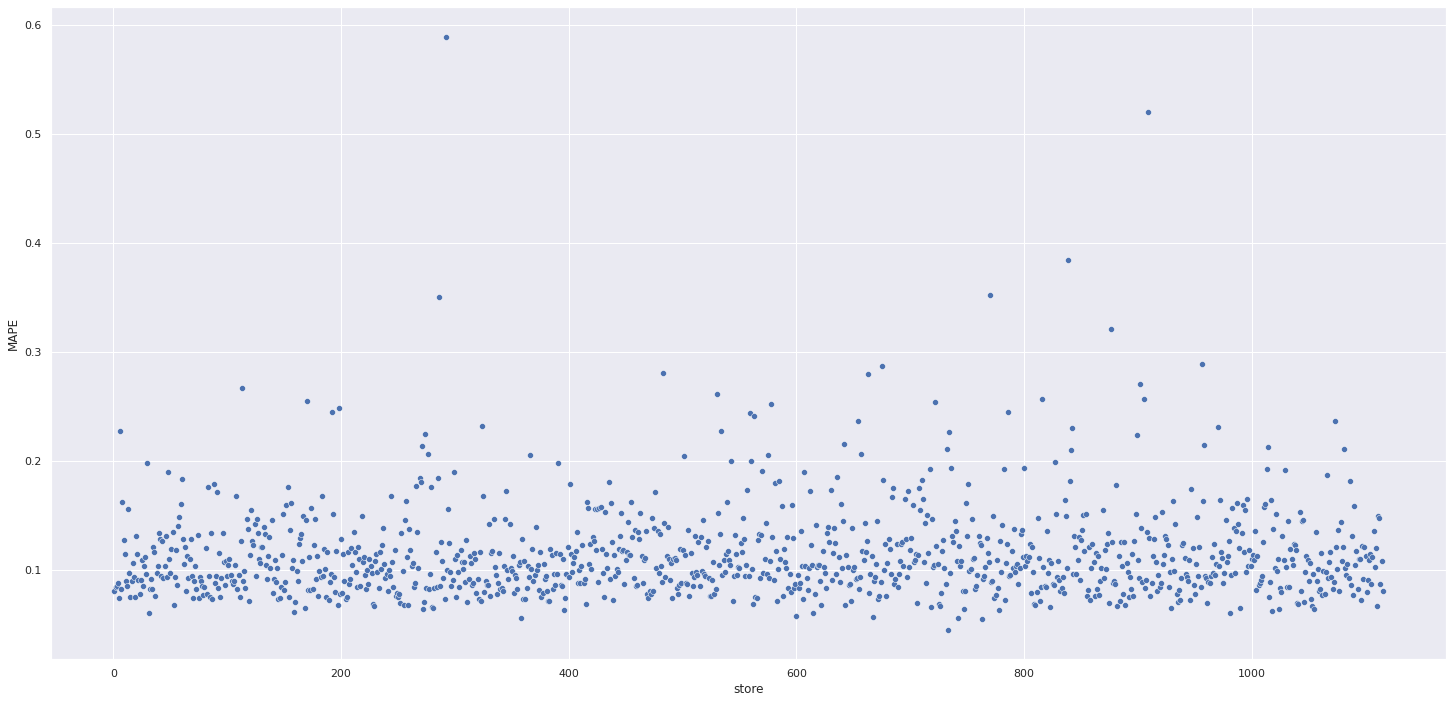

In [109]:
sns.scatterplot(x='store', y='MAPE', data= store_performance);

## 10.2 Performance Total

In [110]:
scenario_total = store_performance[['predictions', 'worst_scenario', 'best_scenario']].sum().reset_index().rename(columns = {'index': 'scenario', 0: 'values'})
scenario_total['values'] = scenario_total['values'].map('R${:,.2f}'.format)
scenario_total

,scenario,values
0,predictions,"R$282,240,096.00"
1,worst_scenario,"R$250,485,125.08"
2,best_scenario,"R$313,995,075.75"


## 10.3 Performance Machine Learning

In [111]:
df10['error'] = df10['sales'] - df10['predictions']
df10['error_rate'] = df10['predictions'] / df10['sales']

/home/giovane/pythonProject/predicao_vendas/vendasPredicao/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='predictions', ylabel='error'>

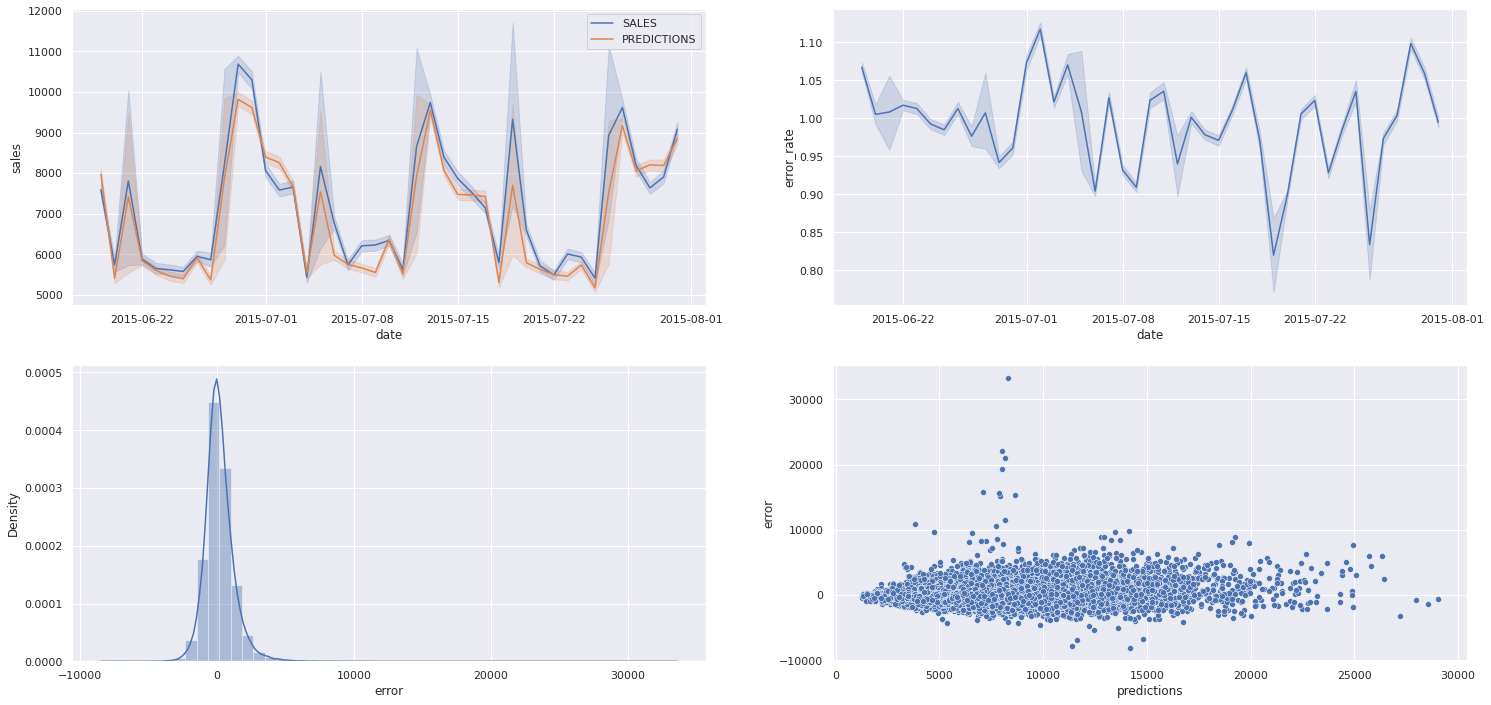

In [112]:
plt.subplot(2,2,1)
sns.lineplot(x = 'date', y='sales', data=df10, label = "SALES")
sns.lineplot(x = 'date', y='predictions', data=df10, label = "PREDICTIONS")

plt.subplot(2,2,2)
sns.lineplot(x = 'date', y='error_rate', data=df10)

plt.subplot(2,2,3)
sns.distplot(df10['error'])

plt.subplot(2,2,4)
sns.scatterplot(x = 'predictions', y = 'error', data=df10)


# 11.0 Deploy Modelo em Producao

In [104]:
# salvando modelo no formato pickle
pickle.dump(model_xgb_tuned, open('/home/giovane/pythonProject/predicao_vendas/model/model_rossmann.pkl', 'wb'))

## 11.1 Rossmann Class

In [8]:
import pickle 
import inflection
import pandas as pd 
import math
import datetime
import numpy as np

class Rossmann(object):
    def __init__(self):
        self.home_path = '/home/giovane/pythonProject/predicao_vendas/'
        self.year_scaler = pickle.load( open(self.home_path + 'parameter/year_scaler.pkl', 'rb'))
        self.store_type_encoding = pickle.load( open(self.home_path + 'parameter/store_type_encoding.pkl', 'rb'))
        self.promo2_time_week_scaler = pickle.load( open(self.home_path + 'parameter/promo2_time_week_scaler.pkl', 'rb'))
        self.promo2_since_year_scaler = pickle.load( open(self.home_path + 'parameter/promo2_since_year_scaler.pkl', 'rb'))
        self.competition_distance_scaler = pickle.load( open(self.home_path + 'parameter/competition_distance_scaler.pkl', 'rb'))
        

    def data_cleaning(self, df2):
        ## 1. Renomea colunas
        cols_old = df2.columns
        snake_case = lambda x : inflection.underscore(x)
        cols_new = list(map(snake_case, cols_old))
        df2.columns = cols_new
        
        # alterando tipo do atributo
        df2['date'] = pd.to_datetime(df2['date'], format='%Y-%m-%d')
        
        ## 2. Preencher dados faltantes, NA
        # competition_distance
        df2['competition_distance'] = df2['competition_distance'].apply(lambda x : 200000.0 if math.isnan(x) 
                                                                        else x )

        # competition_open_since_month
        df2['competition_open_since_month'] = df2.apply(lambda x : x['date'].month 
                                                        if math.isnan(x['competition_open_since_month']) 
                                                                        else x['competition_open_since_month'], axis=1 )

        # competition_open_since_year
        df2['competition_open_since_year'] = df2.apply(lambda x : x['date'].year 
                                                        if math.isnan(x['competition_open_since_year']) 
                                                                        else x['competition_open_since_year'], axis=1 )
        # promo2_since_week
        df2['promo2_since_week'].fillna(0, inplace=True)

        # promo2_since_year
        df2['promo2_since_year'].fillna(0, inplace=True)

        # promo_interval
        month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct'
                     , 11: 'Nov', 12: 'Dec'}

        df2['promo_interval'].fillna(0, inplace=True)
        df2['month_map'] = df2['date'].dt.month.map(month_map)

        df2['is_promo2'] = df2[['promo_interval', 'month_map']].apply(lambda x : 0 if x['promo_interval'] == 0 else
                                                                      1 if x['month_map'] in x['promo_interval'].split(',')
                                                                      else 0, axis=1)
        
        ## 3. Altera Data type 
        # alterando o tipo dos catributos 'promo2_since_week', 'promo2_since_year' para int 
        df2['promo2_since_week'] = df2['promo2_since_week'].astype(int)
        df2['promo2_since_year'] = df2['promo2_since_year'].astype(int)

        # alterando o tipo dos catributos 'competition_open_since_month', 'competition_open_since_year' para int 
        df2['competition_open_since_month'] = df2['competition_open_since_month'].astype(int)
        df2['competition_open_since_year'] = df2['competition_open_since_year'].astype(int)
        
        return df2
    
    
    def feature_engineering(self, df3):
        # criacao de features com base nas ja existentes

        #year
        df3['year'] = df3['date'].dt.year

        #month
        df3['month'] = df3['date'].dt.month

        #day
        df3['day'] = df3['date'].dt.day

        #week of year
        df3['week_of_year'] = df3['date'].dt.weekofyear

        #year week
        df3['year_week'] = df3['date'].dt.strftime('%Y-%W')


        #promo Since
        df3['promo2_since'] = df3['promo2_since_year'].astype(str) + '-' + df3['promo2_since_week'].astype(str)
        df3['promo2_since'] = df3['promo2_since'].apply(lambda x : 0 if x == '0-0' else datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
        df3['promo2_time_week'] = df3.apply(lambda x: 0 if x['promo2_since'] == 0 else ((x['date']-x['promo2_since'])/7).days, axis=1).astype(int)

        #assortiment
        df3['assortment'] = df3['assortment'].apply(lambda x : 'basic' if  x=='a'  else 'extra' if x=='b' else 'extended')

        #state holiday
        df3['state_holiday'] = df3['state_holiday'].apply(lambda x : 'public holiday' if  x=='a' else 'easter holiday' if x=='b' 
                                                          else 'christmas' if x=='c' else 'regular day')
        # Filtragem por linha
        df3 = df3[df3['open']!=0] 

        # Filtragem por coluna
        cols_drop = ['open', 'promo_interval', 'month_map']
        df3 = df3.drop(cols_drop, axis=1)

        return df3
    
    
    def data_preparation(self, df6):
        # 1. Rescalonamento de variaveis
        # competition_distance
        df6['competition_distance'] = self.competition_distance_scaler.fit_transform(df6[['competition_distance']].values)
        
        # year
        df6['year'] = self.year_scaler.fit_transform(df6[['year']].values)
        
        # promo2_time_week
        df6['promo2_time_week'] = self.promo2_time_week_scaler.fit_transform(df6[['promo2_time_week']].values)
        

        # promo2_since_year
        df6['promo2_since_year'] = self.promo2_since_year_scaler.fit_transform(df6[['promo2_since_year']].values)
        
        
        # 2. Encoding de variaveis categoricas
        # state_holiday 
        df6 = pd.get_dummies(df6, prefix= ['state_holiday'], columns=['state_holiday'])

        # store_type 
        df6['store_type'] = self.store_type_encoding.fit_transform(df6['store_type'])
        
        # assortment
        assortment_dict = {'basic' : 1, 'extra' : 2 , 'extended' : 3}
        df6['assortment'] = df6['assortment'].map(assortment_dict)
        
        
        # 3. Transformacao de natureza
        # month
        df6['month_sin'] = df6['month'].apply(lambda x: np.sin(x * (2. * np.pi/12)))
        df6['month_cos'] = df6['month'].apply(lambda x: np.cos(x * (2. * np.pi/12)))

        # day
        df6['day_sin'] = df6['day'].apply(lambda x: np.sin(x * (2. * np.pi/30)))
        df6['day_cos'] = df6['day'].apply(lambda x: np.cos(x * (2. * np.pi/30)))

        # week_of_year
        df6['week_of_year_sin'] = df6['week_of_year'].apply(lambda x: np.sin(x * (2. * np.pi/52)))
        df6['week_of_year_cos'] = df6['week_of_year'].apply(lambda x: np.cos(x * (2. * np.pi/52)))

        # day_of_week
        df6['day_of_week_sin'] = df6['day_of_week'].apply(lambda x: np.sin(x * (2. * np.pi/7)))
        df6['day_of_week_cos'] = df6['day_of_week'].apply(lambda x: np.cos(x * (2. * np.pi/7)))

        # competition_open_since_month
        df6['competition_open_since_month_sin'] = df6['competition_open_since_month'].apply(lambda x: np.sin(x * (2. * np.pi/12)))
        df6['competition_open_since_month_cos'] = df6['competition_open_since_month'].apply(lambda x: np.cos(x * (2. * np.pi/12)))

        # promo2_since_week
        df6['promo2_since_week_sin'] = df6['promo2_since_week'].apply(lambda x: np.sin(x * (2. * np.pi/52)))
        df6['promo2_since_week_cos'] = df6['promo2_since_week'].apply(lambda x: np.cos(x * (2. * np.pi/52)))
        
        cols_selected = ['store','promo', 'store_type', 'assortment', 'competition_distance', 'competition_open_since_year', 'promo2', 
                                'promo2_since_year', 'promo2_time_week', 'month_cos',  'month_sin', 'day_sin', 'day_cos', 'week_of_year_cos',
                                'week_of_year_sin', 'day_of_week_sin', 'day_of_week_cos', 'competition_open_since_month']
        

        return df6[cols_selected]
    
    def get_prediction(self, test_data, original_data, model):
        prediction =  model.predict(test_data)
        
        # juntando predicao com os dados originais
        original_data['prediction'] = np.expm1(prediction)
        
        return original_data.to_json(orient = 'records', date_format = 'iso')
        

## 11.2 API Handler

In [11]:
from flask import Flask, request, Response
from rossmann.Rossman import Rossmann

# carregando modelo
model = pickle.load(open, ('/home/giovane/pythonProject/predicao_vendas/model/model_rossmann.pkl', 'rb'))

app = Flask(__name__)

@app.route('/rossmann/predict', methods=['POST'])
def rossmann_predicr():
    test_json  = request.get_json()
    
    # Valida se a dados na requisicao 
    if test_json:
        #unico json
        if isinstance(test_json, dict):
            test_raw = pd.DataFrame(test_json, index=[0])
            
        #multiplos json
        else:
            test_raw = pd.DataFrame(test_json, columns=test_json[0].keys())
    
    else:
        return Response( '{}', status=200, mimetype ='aplication/json') 
    
    # Instasiando classe Rossmann
    pipeline = Rossmann()
    
    # limpeza dos dados
    df1 = pipeline.data_cleaning(test_raw)
    
    # feature engineering e filtragem 
    df2 = pipeline.feature_engineering(df1)
    
    # preparacao dos dados, modelagem 
    df3 = pipeline.data_preparation(df2)
    
    # prediction
    df_response = pipeline.get_prediction(df3,test_raw, model)
    
    return df_response
    
if __name__ == '__main__':
    app.run('0.0.0.0')

ModuleNotFoundError: No module named 'rossmann'

## 11.3 Rossmann Tester

In [8]:
import requests

In [9]:
df11 = pd.read_csv('/home/giovane/pythonProject/predicao_vendas/data/raw/test.csv')

In [10]:
# merge test dataset + store
df_test = pd.merge(df11, df_store_raw, how = 'left', on = 'Store')

# escolha da loja para o teste 
df_test = df_test[df_test['Store'] == 22]

# removendo dias fechados 
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()]
df_test = df_test.drop('Id', axis=1)

In [13]:
# converter dataframe para json
data_teste = json.dumps(df_test.to_dict(orient='records'))

In [14]:
# API request 
url = 'https://rossmann-prediction-sale.herokuapp.com/rossmann/predict'
header = {'Content-type': 'application/json'} 
data = data_teste

r = requests.post( url, data = data, headers = header)
print('Status code: {}'.format(r.status_code))

Status code: 200


In [15]:
df_prediction = pd.DataFrame(r.json(), columns=r.json()[0].keys())

In [16]:
df_prediction['prediction'].sum()

167042.92675781262

In [17]:
df_prediction

,store,day_of_week,date,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo2,year,month,day,week_of_year,year_week,promo2_since,promo2_time_week,prediction
0,22,4,2015-09-17T00:00:00.000Z,1.0,1,regular day,0,a,basic,1040.0,9,2015,1,22,2012,"Jan,Apr,Jul,Oct",Sep,0,2015,9,17,38,2015-37,2012-05-21T00:00:00.000Z,173,4349.329590
1,22,3,2015-09-16T00:00:00.000Z,1.0,1,regular day,0,a,basic,1040.0,9,2015,1,22,2012,"Jan,Apr,Jul,Oct",Sep,0,2015,9,16,38,2015-37,2012-05-21T00:00:00.000Z,173,4247.476562
2,22,2,2015-09-15T00:00:00.000Z,1.0,1,regular day,0,a,basic,1040.0,9,2015,1,22,2012,"Jan,Apr,Jul,Oct",Sep,0,2015,9,15,38,2015-37,2012-05-21T00:00:00.000Z,173,5118.385254
3,22,1,2015-09-14T00:00:00.000Z,1.0,1,regular day,1,a,basic,1040.0,9,2015,1,22,2012,"Jan,Apr,Jul,Oct",Sep,0,2015,9,14,38,2015-37,2012-05-21T00:00:00.000Z,173,5957.900391
4,22,6,2015-09-12T00:00:00.000Z,1.0,0,regular day,0,a,basic,1040.0,9,2015,1,22,2012,"Jan,Apr,Jul,Oct",Sep,0,2015,9,12,37,2015-36,2012-05-21T00:00:00.000Z,172,2835.456055
5,22,5,2015-09-11T00:00:00.000Z,1.0,0,regular day,1,a,basic,1040.0,9,2015,1,22,2012,"Jan,Apr,Jul,Oct",Sep,0,2015,9,11,37,2015-36,2012-05-21T00:00:00.000Z,172,3103.927734
6,22,4,2015-09-10T00:00:00.000Z,1.0,0,regular day,1,a,basic,1040.0,9,2015,1,22,2012,"Jan,Apr,Jul,Oct",Sep,0,2015,9,10,37,2015-36,2012-05-21T00:00:00.000Z,172,3155.127930
7,22,3,2015-09-09T00:00:00.000Z,1.0,0,regular day,1,a,basic,1040.0,9,2015,1,22,2012,"Jan,Apr,Jul,Oct",Sep,0,2015,9,9,37,2015-36,2012-05-21T00:00:00.000Z,172,3040.312012
8,22,2,2015-09-08T00:00:00.000Z,1.0,0,regular day,1,a,basic,1040.0,9,2015,1,22,2012,"Jan,Apr,Jul,Oct",Sep,0,2015,9,8,37,2015-36,2012-05-21T00:00:00.000Z,172,3322.764648
9,22,1,2015-09-07T00:00:00.000Z,1.0,0,regular day,1,a,basic,1040.0,9,2015,1,22,2012,"Jan,Apr,Jul,Oct",Sep,0,2015,9,7,37,2015-36,2012-05-21T00:00:00.000Z,172,3488.419678
